### BDP Final Project: Twitter Credibility Analysis on Special Education - Part 3: Location Analysis

In [1]:
spark.version

'3.1.3'

In [2]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install pycountry_convert

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pycountry
import pycountry_convert as pc
from pyspark.sql.functions import to_timestamp

import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
path = 'gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1'

In [9]:
edu_df = spark.read.parquet(path)

In [10]:
edu_df.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet
1597115277602430981,0,Mon Nov 28 06:28:...,0,en,happy total secti...,1587123926022656000,Priscilla Harris,the same items fr...,110,531,false,Mon Oct 31 16:47:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115281717227521,0,Mon Nov 28 06:28:...,0,en,#rc16 graduation ...,1512661462438752265,Suguna College of...,Suguna College of...,2,0,false,Sat Apr 09 05:53:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115288541331456,0,Mon Nov 28 06:28:...,0,en,#卡塔尔世界杯 #世界杯下注 ht...,1530512461220257792,天博体育 AOA体育 开云体育 世...,AOA体育http://aoa85...,0,0,false,Sat May 28 11:33:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115289325314049,0,Mon Nov 28 06:28:...,0,en,use of any relati...,1587149413054570497,Kimberly Olson,last day i found ...,110,592,false,Mon Oct 31 18:28:...,null,null,null,false,null,null,null,null,null,null,null,null,true
1597115289950638080,0,Mon Nov 28 06:28:...,0,en,i’m finally gradu...,389316573,c__c,Love you to the m...,60,26599,false,Wed Oct 12 06:30:...,null,null,null,true,yadarilya,Mon Nov 28 04:58:...,98,26,9,[],1405450842199654404,1597092424912097280,false


In [11]:
edu_df.count()

33490185

In [12]:
path2 = 'gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2'

In [13]:
tweeter_cat = spark.read.parquet(path2)

In [14]:
tweeter_cat.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullabl

In [15]:
tweeter_cat.count()

27566156

#### **Change Data Type**

In [16]:
# change dataType
tweeter_cat = tweeter_cat.withColumn('tweet_reply_count', tweeter_cat['tweet_reply_count'].cast(IntegerType())) \
           .withColumn('tweet_likes', tweeter_cat['tweet_likes'].cast(IntegerType()))\
           .withColumn('user_followers_count', tweeter_cat['user_followers_count'].cast(IntegerType()))\
           .withColumn('user_like_count', tweeter_cat['user_like_count'].cast(IntegerType()))\
           .withColumn('rt_likes', tweeter_cat['rt_likes'].cast(IntegerType()))\
           .withColumn('rt_count', tweeter_cat['rt_count'].cast(IntegerType()))\
           .withColumn('rt_reply_count', tweeter_cat['rt_reply_count'].cast(IntegerType()))

In [17]:
tweeter_cat.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: integer (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: integer (nullable = true)
 |-- user_like_count: integer (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: integer (nullable = true)
 |-- rt_count: integer (nullable = true)
 |-- rt_reply_count: integer (nullable = true)
 |-- rt_has

In [18]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/chihhan/final_project_part2_data_type'

In [19]:
tweeter_cat.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

In [20]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

Found 6 items
drwx------   - root root          0 2023-03-04 01:06 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V1
drwx------   - root root          0 2023-03-04 15:02 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V2
drwx------   - root root          0 2023-03-06 16:49 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2
drwx------   - root root          0 2023-03-06 16:23 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1
drwx------   - root root          0 2023-03-07 16:01 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_data_type
drwx------   - root root          0 2023-03-07 14:12 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_time_change


In [21]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_data_type')

In [22]:
df.count()

27566156

In [23]:
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: integer (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: integer (nullable = true)
 |-- user_like_count: integer (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: integer (nullable = true)
 |-- rt_count: integer (nullable = true)
 |-- rt_reply_count: integer (nullable = true)
 |-- rt_has

#### **Change Time Format**

**using Tweeter_category dataset**

In [24]:
time_df = tweeter_cat.select(['time_tweet_created', 'time_account_created', 'rt_created_time']).limit(5).toPandas()
time_df

,time_tweet_created,time_account_created,rt_created_time
0,Fri Apr 15 14:29:12 +0000 2022,Tue Oct 29 18:40:06 +0000 2019,None
1,Fri Apr 15 14:29:14 +0000 2022,Thu Jan 12 21:48:37 +0000 2017,Fri Apr 15 13:12:32 +0000 2022
2,Fri Apr 15 14:29:14 +0000 2022,Tue Jun 07 01:40:24 +0000 2011,None
3,Fri Apr 15 14:29:15 +0000 2022,Wed Dec 19 17:57:08 +0000 2018,Thu Apr 14 15:11:55 +0000 2022
4,Fri Apr 15 14:29:15 +0000 2022,Tue Jul 24 19:04:38 +0000 2018,Fri Apr 15 14:28:12 +0000 2022


In [25]:
time_df['day'] = time_df['time_tweet_created'].str.split(" ").str[0]
time_df

,time_tweet_created,time_account_created,rt_created_time,day
0,Fri Apr 15 14:29:12 +0000 2022,Tue Oct 29 18:40:06 +0000 2019,None,Fri
1,Fri Apr 15 14:29:14 +0000 2022,Thu Jan 12 21:48:37 +0000 2017,Fri Apr 15 13:12:32 +0000 2022,Fri
2,Fri Apr 15 14:29:14 +0000 2022,Tue Jun 07 01:40:24 +0000 2011,None,Fri
3,Fri Apr 15 14:29:15 +0000 2022,Wed Dec 19 17:57:08 +0000 2018,Thu Apr 14 15:11:55 +0000 2022,Fri
4,Fri Apr 15 14:29:15 +0000 2022,Tue Jul 24 19:04:38 +0000 2018,Fri Apr 15 14:28:12 +0000 2022,Fri


In [26]:
time_df['month'] = time_df['time_tweet_created'].str.split(" ").str[1]
time_df

,time_tweet_created,time_account_created,rt_created_time,day,month
0,Fri Apr 15 14:29:12 +0000 2022,Tue Oct 29 18:40:06 +0000 2019,None,Fri,Apr
1,Fri Apr 15 14:29:14 +0000 2022,Thu Jan 12 21:48:37 +0000 2017,Fri Apr 15 13:12:32 +0000 2022,Fri,Apr
2,Fri Apr 15 14:29:14 +0000 2022,Tue Jun 07 01:40:24 +0000 2011,None,Fri,Apr
3,Fri Apr 15 14:29:15 +0000 2022,Wed Dec 19 17:57:08 +0000 2018,Thu Apr 14 15:11:55 +0000 2022,Fri,Apr
4,Fri Apr 15 14:29:15 +0000 2022,Tue Jul 24 19:04:38 +0000 2018,Fri Apr 15 14:28:12 +0000 2022,Fri,Apr


In [27]:
time_df['date'] = time_df['time_tweet_created'].str.split(" ").str[2]
time_df

,time_tweet_created,time_account_created,rt_created_time,day,month,date
0,Fri Apr 15 14:29:12 +0000 2022,Tue Oct 29 18:40:06 +0000 2019,None,Fri,Apr,15
1,Fri Apr 15 14:29:14 +0000 2022,Thu Jan 12 21:48:37 +0000 2017,Fri Apr 15 13:12:32 +0000 2022,Fri,Apr,15
2,Fri Apr 15 14:29:14 +0000 2022,Tue Jun 07 01:40:24 +0000 2011,None,Fri,Apr,15
3,Fri Apr 15 14:29:15 +0000 2022,Wed Dec 19 17:57:08 +0000 2018,Thu Apr 14 15:11:55 +0000 2022,Fri,Apr,15
4,Fri Apr 15 14:29:15 +0000 2022,Tue Jul 24 19:04:38 +0000 2018,Fri Apr 15 14:28:12 +0000 2022,Fri,Apr,15


In [28]:
time_df['time'] = time_df['time_tweet_created'].str.split(" ").str[3]
time_df

,time_tweet_created,time_account_created,rt_created_time,day,month,date,time
0,Fri Apr 15 14:29:12 +0000 2022,Tue Oct 29 18:40:06 +0000 2019,None,Fri,Apr,15,14:29:12
1,Fri Apr 15 14:29:14 +0000 2022,Thu Jan 12 21:48:37 +0000 2017,Fri Apr 15 13:12:32 +0000 2022,Fri,Apr,15,14:29:14
2,Fri Apr 15 14:29:14 +0000 2022,Tue Jun 07 01:40:24 +0000 2011,None,Fri,Apr,15,14:29:14
3,Fri Apr 15 14:29:15 +0000 2022,Wed Dec 19 17:57:08 +0000 2018,Thu Apr 14 15:11:55 +0000 2022,Fri,Apr,15,14:29:15
4,Fri Apr 15 14:29:15 +0000 2022,Tue Jul 24 19:04:38 +0000 2018,Fri Apr 15 14:28:12 +0000 2022,Fri,Apr,15,14:29:15


In [29]:
time_df['year'] = time_df['time_tweet_created'].str.split(" ").str[-1]
time_df

,time_tweet_created,time_account_created,rt_created_time,day,month,date,time,year
0,Fri Apr 15 14:29:12 +0000 2022,Tue Oct 29 18:40:06 +0000 2019,None,Fri,Apr,15,14:29:12,2022
1,Fri Apr 15 14:29:14 +0000 2022,Thu Jan 12 21:48:37 +0000 2017,Fri Apr 15 13:12:32 +0000 2022,Fri,Apr,15,14:29:14,2022
2,Fri Apr 15 14:29:14 +0000 2022,Tue Jun 07 01:40:24 +0000 2011,None,Fri,Apr,15,14:29:14,2022
3,Fri Apr 15 14:29:15 +0000 2022,Wed Dec 19 17:57:08 +0000 2018,Thu Apr 14 15:11:55 +0000 2022,Fri,Apr,15,14:29:15,2022
4,Fri Apr 15 14:29:15 +0000 2022,Tue Jul 24 19:04:38 +0000 2018,Fri Apr 15 14:28:12 +0000 2022,Fri,Apr,15,14:29:15,2022


In [30]:
time = tweeter_cat.withColumn('tweet_created_week_day', split(tweeter_cat['time_tweet_created'], ' ').getItem(0)) \
           .withColumn('tweet_created_month', split(tweeter_cat['time_tweet_created'], ' ').getItem(1)) \
           .withColumn('tweet_created_day', split(tweeter_cat['time_tweet_created'], ' ').getItem(2)) \
           .withColumn('tweet_created_time', split(tweeter_cat['time_tweet_created'], ' ').getItem(3)) \
           .withColumn('tweet_created_offset', split(tweeter_cat['time_tweet_created'], ' ').getItem(4)) \
           .withColumn('tweet_created_year', split(tweeter_cat['time_tweet_created'], ' ').getItem(5))

In [31]:
time.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_offset,tweet_created_year
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,mit.nano,we measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other,Fri,Apr,15,14:29:12,+0000,2022
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,true,EAlexander46,Fri Apr 15 13:12:...,231,54,9,[],1351258907113648128,1514954830141399040,false,other,Fri,Apr,15,14:29:14,+0000,2022


In [32]:
time = time.withColumn('account_created_week_day', split(time['time_account_created'], ' ').getItem(0)) \
           .withColumn('account_created_month', split(time['time_account_created'], ' ').getItem(1)) \
           .withColumn('account_created_day', split(time['time_account_created'], ' ').getItem(2)) \
           .withColumn('account_created_time', split(time['time_account_created'], ' ').getItem(3)) \
           .withColumn('account_created_offset', split(time['time_account_created'], ' ').getItem(4)) \
           .withColumn('account_created_year', split(time['time_account_created'], ' ').getItem(5))

In [33]:
time.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_offset,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_offset,account_created_year
1588924230477185027,0,Sat Nov 05 16:00:...,0,en,have you heard ab...,1037286691,elise tak,"visual artist, cu...",789,90005,false,Wed Dec 26 14:37:...,null,null,null,true,BTnewsroom,Fri Nov 04 15:14:...,47,33,0,[],1217207858435186689,1588550156646895616,false,other,Sat,Nov,05,16:00:31,+0000,2022,Wed,Dec,26,14:37:21,+0000,2012
1588924237473058816,0,Sat Nov 05 16:00:...,0,en,#rondesantisisana...,1288265938190598150,pam slaw,school psychologi...,74,3246,false,Wed Jul 29 00:12:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other,Sat,Nov,05,16:00:33,+0000,2022,Wed,Jul,29,00:12:00,+0000,2020
1588924240203763714,0,Sat Nov 05 16:00:...,0,en,@86824ce248804bb ...,2337976855,waxed unreal,paramount icon of...,1398,401849,false,Tue Feb 11 08:00:...,null,null,null,true,Jprairieperson,Sat Nov 05 15:31:...,4,2,1,[],2800143476,1588917023085842438,false,other,Sat,Nov,05,16:00:34,+0000,2022,Tue,Feb,11,08:00:47,+0000,2014
1588924241659166721,0,Sat Nov 05 16:00:...,0,en,beware of statin ...,97165333,lesliekenton.com,natural healthy &...,472,4,false,Wed Dec 16 08:16:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other,Sat,Nov,05,16:00:34,+0000,2022,Wed,Dec,16,08:16:35,+0000,2009
1588924255651377152,0,Sat Nov 05 16:00:...,0,en,itw david speer a...,1440669270975811593,sporttv༝,high school sport,11,64,false,Wed Sep 22 13:28:...,null,null,null,false,null,null,null,null,null,null,null,null,true,universities,Sat,Nov,05,16:00:37,+0000,2022,Wed,Sep,22,13:28:32,+0000,2021


In [34]:
# time = time.withColumn('rt_created_week_day', split(time['rt_created_time'], ' ').getItem(0)) \
#            .withColumn('rt_created_month', split(time['rt_created_time'], ' ').getItem(1)) \
#            .withColumn('rt_created_day', split(time['rt_created_time'], ' ').getItem(2)) \
#            .withColumn('rt_created_time', split(time['rt_created_time'], ' ').getItem(3)) \
#            .withColumn('rt_created_offset', split(time['rt_created_time'], ' ').getItem(4)) \
#            .withColumn('rt_created_year', split(time['rt_created_time'], ' ').getItem(5))

In [91]:
# convert month to standard MM
time = time.withColumn('tweet_created_month_num', from_unixtime(unix_timestamp(col('tweet_created_month'), 'MMM'), 'MM'))
time = time.withColumn('account_created_month_num', from_unixtime(unix_timestamp(col('account_created_month'), 'MMM'), 'MM'))

In [92]:
time.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_offset,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_offset,account_created_year,tweet_created_month_num,account_created_month_num
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,mit.nano,we measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other,Fri,Apr,15,14:29:12,+0000,2022,Tue,Oct,29,18:40:06,+0000,2019,04,10
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,true,EAlexander46,Fri Apr 15 13:12:...,231,54,9,[],1351258907113648128,1514954830141399040,false,other,Fri,Apr,15,14:29:14,+0000,2022,Thu,Jan,12,21:48:37,+0000,2017,04,01


In [93]:
# merge the YYYY-MM-DD
time = time.withColumn('tweet_created_date_merge', concat_ws('-', 'tweet_created_year', 'tweet_created_month_num', 'tweet_created_day')) \
           .withColumn('tweet_created_date', to_date('tweet_created_date_merge', 'yyyy-MM-dd')) \
           .withColumn('account_created_date_merge', concat_ws('-', 'account_created_year', 'account_created_month_num', 'account_created_day')) \
           .withColumn('account_created_date', to_date('account_created_date_merge', 'yyyy-MM-dd')) \
           .drop('tweet_created_date_merge') \
           .drop('account_created_date_merge')

In [94]:
time.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_offset,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_offset,account_created_year,tweet_created_month_num,account_created_month_num,tweet_created_date,account_created_date
1514974123751088133,0,Fri Apr 15 14:29:...,0,en,join us 4/25 for ...,1189250547355811840,mit.nano,we measure the fu...,1522,1501,false,Tue Oct 29 18:40:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other,Fri,Apr,15,14:29:12,+0000,2022,Tue,Oct,29,18:40:06,+0000,2019,04,10,2022-04-15,2019-10-29
1514974131434971140,0,Fri Apr 15 14:29:...,0,en,a teacher for mor...,819662390149214208,dan marshall,ontario correctio...,243,11515,false,Thu Jan 12 21:48:...,null,null,null,true,EAlexander46,Fri Apr 15 13:12:...,231,54,9,[],1351258907113648128,1514954830141399040,false,other,Fri,Apr,15,14:29:14,+0000,2022,Thu,Jan,12,21:48:37,+0000,2017,04,01,2022-04-15,2017-01-12


In [96]:
time = time.drop('tweet_created_offset', 'account_created_offset', 'rt_created_time')

In [97]:
time.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_year,tweet_created_month_num,account_created_month_num,tweet_created_date,account_created_date
1609295925494661125,0,Sat Dec 31 21:10:...,0,en,2022 (academics) ...,223643557,miss sam,"a life of faith,a...",5225,4002,false,Mon Dec 06 23:20:...,null,null,null,true,xorlaliplange,294,61,13,[],713856387315589121,1609245304901050371,false,other,Sat,Dec,31,21:10:22,2022,Mon,Dec,06,23:20:31,2010,12,12,2022-12-31,2010-12-06
1609295925578530824,0,Sat Dec 31 21:10:...,0,en,the median ifr fo...,834624054099337216,babydoll92196 wha...,love our country ...,740,35591,false,Thu Feb 23 04:40:...,null,null,null,true,PatriotSkyrific,96,43,1,[],826112727311589376,1608963400851419137,false,other,Sat,Dec,31,21:10:22,2022,Thu,Feb,23,04:40:55,2017,12,02,2022-12-31,2017-02-23


In [98]:
time.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: integer (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: integer (nullable = true)
 |-- user_like_count: integer (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_likes: integer (nullable = true)
 |-- rt_count: integer (nullable = true)
 |-- rt_reply_count: integer (nullable = true)
 |-- rt_hashtags: array (nullable = true)
 |    |-- elemen

#### **Save date format(with twitterer category) into individual bucket**

In [35]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/chihhan/final_project_part2_time_change'

In [36]:
time.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

In [37]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

Found 6 items
drwx------   - root root          0 2023-03-04 01:06 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V1
drwx------   - root root          0 2023-03-04 15:02 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V2
drwx------   - root root          0 2023-03-06 16:49 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2
drwx------   - root root          0 2023-03-06 16:23 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1
drwx------   - root root          0 2023-03-07 16:01 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_data_type
drwx------   - root root          0 2023-03-07 16:04 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_time_change


In [38]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_time_change')

In [39]:
df.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_offset,tweet_created_year,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_offset,account_created_year
1588924230477185027,0,Sat Nov 05 16:00:...,0,en,have you heard ab...,1037286691,elise tak,"visual artist, cu...",789,90005,false,Wed Dec 26 14:37:...,null,null,null,true,BTnewsroom,Fri Nov 04 15:14:...,47,33,0,[],1217207858435186689,1588550156646895616,false,other,Sat,Nov,05,16:00:31,+0000,2022,Wed,Dec,26,14:37:21,+0000,2012
1588924237473058816,0,Sat Nov 05 16:00:...,0,en,#rondesantisisana...,1288265938190598150,pam slaw,school psychologi...,74,3246,false,Wed Jul 29 00:12:...,null,null,null,false,null,null,null,null,null,null,null,null,true,other,Sat,Nov,05,16:00:33,+0000,2022,Wed,Jul,29,00:12:00,+0000,2020


In [40]:
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: integer (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: integer (nullable = true)
 |-- user_like_count: integer (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: integer (nullable = true)
 |-- rt_count: integer (nullable = true)
 |-- rt_reply_count: integer (nullable = true)
 |-- rt_has

**using edu_df dataset**

In [130]:
time = edu_df.withColumn('tweet_created_week_day', split(edu_df['time_tweet_created'], ' ').getItem(0)) \
           .withColumn('tweet_created_month', split(edu_df['time_tweet_created'], ' ').getItem(1)) \
           .withColumn('tweet_created_day', split(edu_df['time_tweet_created'], ' ').getItem(2)) \
           .withColumn('tweet_created_time', split(edu_df['time_tweet_created'], ' ').getItem(3)) \
           .withColumn('tweet_created_offset', split(edu_df['time_tweet_created'], ' ').getItem(4)) \
           .withColumn('tweet_created_year', split(edu_df['time_tweet_created'], ' ').getItem(5))

In [131]:
time = time.withColumn('account_created_week_day', split(time['time_account_created'], ' ').getItem(0)) \
           .withColumn('account_created_month', split(time['time_account_created'], ' ').getItem(1)) \
           .withColumn('account_created_day', split(time['time_account_created'], ' ').getItem(2)) \
           .withColumn('account_created_time', split(time['time_account_created'], ' ').getItem(3)) \
           .withColumn('account_created_offset', split(time['time_account_created'], ' ').getItem(4)) \
           .withColumn('account_created_year', split(time['time_account_created'], ' ').getItem(5))

In [132]:
time = time.withColumn('tweet_created_month_num', from_unixtime(unix_timestamp(col('tweet_created_month'), 'MMM'), 'MM'))
time = time.withColumn('account_created_month_num', from_unixtime(unix_timestamp(col('account_created_month'), 'MMM'), 'MM'))

In [133]:
# merge the YYYY-MM-DD
time = time.withColumn('tweet_created_date_merge', concat_ws('-', 'tweet_created_year', 'tweet_created_month_num', 'tweet_created_day')) \
           .withColumn('tweet_created_date', to_date('tweet_created_date_merge', 'yyyy-MM-dd')) \
           .withColumn('account_created_date_merge', concat_ws('-', 'account_created_year', 'account_created_month_num', 'account_created_day')) \
           .withColumn('account_created_date', to_date('account_created_date_merge', 'yyyy-MM-dd')) \
           .drop('tweet_created_date_merge') \
           .drop('account_created_date_merge')

In [134]:
time = time.drop('tweet_created_offset', 'account_created_offset', 'rt_created_time')

In [135]:
time.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullable = true)
 |    |-- element: string (containsNu

In [136]:
time.count()

33490185

#### **Save date format without twitterer category into individual bucket**

In [137]:
bucket_write='msca-bdp-students-bucket'
folder_write = 'shared_data/chihhan/final_project_part2_date_format'

In [138]:
time.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_write + '/'+folder_write)

In [139]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/chihhan'

Found 7 items
drwx------   - root root          0 2023-03-04 01:06 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V1
drwx------   - root root          0 2023-03-04 15:02 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part1_V2
drwx------   - root root          0 2023-03-06 16:49 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2
drwx------   - root root          0 2023-03-06 16:23 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_V1
drwx------   - root root          0 2023-03-07 16:01 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_data_type
drwx------   - root root          0 2023-03-07 18:48 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_date_format
drwx------   - root root          0 2023-03-07 16:04 gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_time_change


In [143]:
date_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_date_format')

In [144]:
date_df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullable = true)
 |    |-- element: string (containsNu

In [145]:
date_df.count()

33490185

####  **3.1 Where are these Twitterers (all of them, not just influencers) located?**

##### **Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?**

In [147]:
country = date_df.filter((date_df.country_code.isNotNull()) & (date_df.country_code != 'None'))
country = country.select(['country_code', 'country_name', 'tweet_created_week_day','tweet_created_month', 'tweet_created_day', 'tweet_created_time', 'tweet_created_year',\
                          'tweet_created_date', 'account_created_week_day', 'account_created_month', 'account_created_day', 'account_created_time', 'account_created_year',\
                          'account_created_date'])

country.limit(1)

country_code,country_name,tweet_created_week_day,tweet_created_month,tweet_created_day,tweet_created_time,tweet_created_year,tweet_created_date,account_created_week_day,account_created_month,account_created_day,account_created_time,account_created_year,account_created_date
IN,India,Wed,Dec,14,13:49:01,2022,2022-12-14,Fri,Feb,25,05:32:27,2022,2022-02-25


**Analyze tweet_created_date trend by country**

In [148]:
country_tweet_time = country.groupBy(['country_code', 'tweet_created_date']).count().orderBy('count', ascending=False)

In [150]:
country_pd_day = country_tweet_time.toPandas()

In [152]:
country_pd_day.sort_values(by='tweet_created_date', ascending=False)

,country_code,tweet_created_date,count
7604,NZ,2023-02-08,1
6697,BR,2023-02-08,1
4144,ZA,2023-02-08,3
8766,TZ,2023-02-08,1
5080,BD,2023-02-08,2
...,...,...,...
1908,IE,2022-04-05,10
11501,GR,2022-04-05,1
5042,ZM,2022-04-05,2
2677,AU,2022-04-05,6


- **Top 10 Total Tweet Count By Country**

In [153]:
country_pd_top10 = country_pd_day[country_pd_day['country_code'].str.contains('US') |\
                                  country_pd_day['country_code'].str.contains('IN') |\
                                  country_pd_day['country_code'].str.contains('GB') |\
                                  country_pd_day['country_code'].str.contains('SA') |\
                                  country_pd_day['country_code'].str.contains('CA') |\
                                  country_pd_day['country_code'].str.contains('NG') |\
                                  country_pd_day['country_code'].str.contains('AU') |\
                                  country_pd_day['country_code'].str.contains('IE') |\
                                  country_pd_day['country_code'].str.contains('PH') |\
                                  country_pd_day['country_code'].str.contains('PK') ]

In [154]:
country_pd_top10

,country_code,tweet_created_date,count
0,US,2022-09-03,1297
1,US,2022-08-25,1287
2,US,2022-09-02,1274
3,US,2022-08-27,1206
4,US,2022-09-10,1159
...,...,...,...
11836,PH,2023-01-04,1
11852,PH,2022-06-06,1
12114,SA,2023-02-02,1
12182,IE,2022-08-10,1


In [157]:
country_pd_top10['tweet_created_date'] = pd.to_datetime(country_pd_top10['tweet_created_date'], format='%Y-%m-%d')

In [ ]:
# 0	United States	201415
# 1	India	20112
# 2	United Kingdom	17500
# 3	Kingdom of Saudi Arabia	12046
# 4	Canada	6405
# 5	Nigeria	3774
# 6	Australia	2795
# 7	Saudi Arabia 2728
# 8	Ireland	2278
# 9	Republic of the Philippines	2260

In [158]:
country_pd_top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3064 entries, 0 to 12389
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   country_code        3064 non-null   object        
 1   tweet_created_date  3064 non-null   datetime64[ns]
 2   count               3064 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 95.8+ KB


In [159]:
#dataFrame.groupby(pd.Grouper(key='Date_of_Purchase', axis=0, freq='M')).sum()
country_by_date = country_pd_top10.groupby([pd.Grouper(key='tweet_created_date', axis=0, freq='M'), 'country_code']).sum('count').unstack()

In [160]:
country_by_date

count                                                  
country_code          AU   CA    GB   IE    IN   NG   PH   PK    SA     US
tweet_created_date                                                        
2022-04-30           181  518  1071  189  1595  352  144  190   389  15365
2022-05-31           315  639  1745  253  1818  396  227  177   141  19479
2022-06-30           281  598  1802  211  2002  420  229  209   305  17570
2022-07-31           246  477  1954  158  2163  382  262  142   203  16877
2022-08-31           323  605  1546  213  2302  397  312  190   541  24037
2022-09-30           313  790  1907  289  2370  351  236  220  2177  23686
2022-10-31           323  748  1895  296  1959  421  236  221  2744  21589
2022-11-30           289  792  2047  285  2104  409  211  213  6361  21224
2022-12-31           235  495  1507  190  1910  296  205  242  1908  18446
2023-01-31           228  614  1532  183  1626  278  159  178    29  18703
2023-02-28            61  151   563   44   432   72   50   32     5   4775

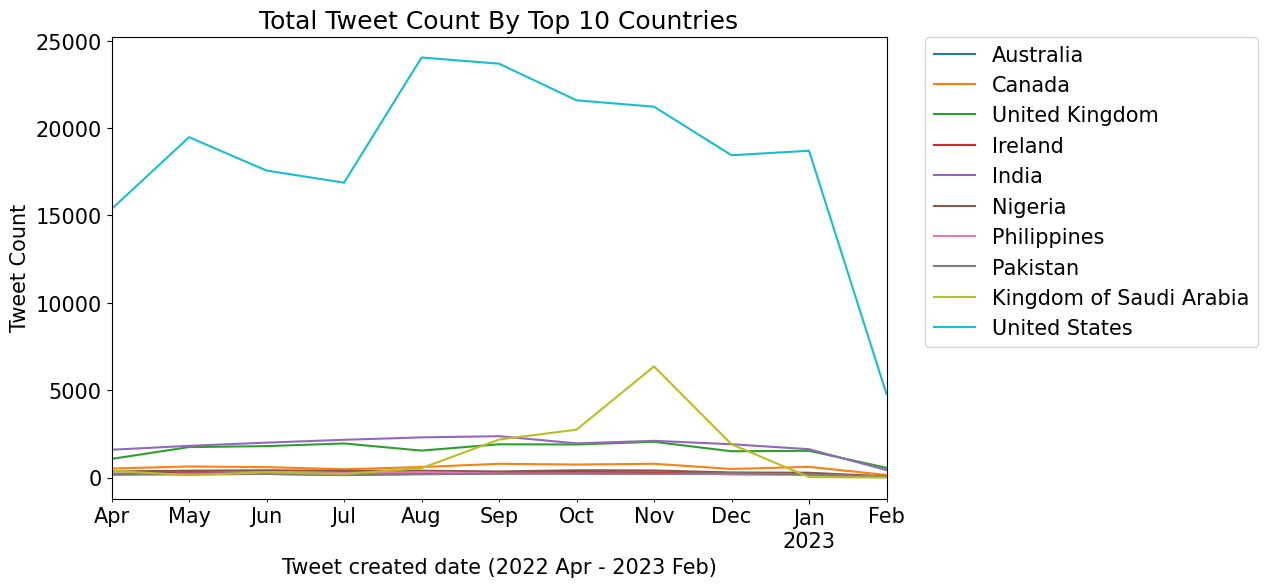

In [225]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 15})


# Extract the country code from the original labels
labels = [label[-1] for label in country_by_date.columns]
labels = [s.replace('US', 'United States') for s in labels]
labels = [s.replace('IN', 'India') for s in labels]
labels = [s.replace('GB', 'United Kingdom') for s in labels]
labels = [s.replace('SA', 'Kingdom of Saudi Arabia') for s in labels]
labels = [s.replace('CA', 'Canada') for s in labels]
labels = [s.replace('NG', 'Nigeria') for s in labels]
labels = [s.replace('AU', 'Australia') for s in labels]
labels = [s.replace('IE', 'Ireland') for s in labels]
labels = [s.replace('PH', 'Philippines') for s in labels]
labels = [s.replace('PK', 'Pakistan') for s in labels]


country_by_date.plot(title='Total Tweet Count By Top 10 Countries', ylabel='Tweet Count', xlabel = 'Tweet created date (2022 Apr - 2023 Feb)')

plt.legend(labels,loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()

- **Top 5 Total Tweet Count By Country**

In [181]:
country_pd_top5 = country_pd_day[country_pd_day['country_code'].str.contains('US') |\
                                  country_pd_day['country_code'].str.contains('IN') |\
                                  country_pd_day['country_code'].str.contains('GB') |\
                                  country_pd_day['country_code'].str.contains('SA') |\
                                  country_pd_day['country_code'].str.contains('CA') ]

In [182]:
country_pd_top5

,country_code,tweet_created_date,count
0,US,2022-09-03,1297
1,US,2022-08-25,1287
2,US,2022-09-02,1274
3,US,2022-08-27,1206
4,US,2022-09-10,1159
...,...,...,...
11206,SA,2023-02-05,1
11273,SA,2023-01-30,1
11383,SA,2022-07-15,1
11543,SA,2023-01-02,1


In [183]:
country_pd_top5['tweet_created_date'] = pd.to_datetime(country_pd_top5['tweet_created_date'], format='%Y-%m-%d')

In [187]:
country_pd_top5['country_name'] = country_pd_top5['country_code'].replace('US', 'United States')
country_pd_top5['country_name'] = country_pd_top5['country_code'].replace('IN', 'India')
country_pd_top5['country_name'] = country_pd_top5['country_code'].replace('GB', 'United Kingdom')
country_pd_top5['country_name'] = country_pd_top5['country_code'].replace('SA', 'Kingdom of Saudi Arabia')
country_pd_top5['country_name'] = country_pd_top5['country_code'].replace('CA', 'Canada')

In [186]:
country_pd_top5['country_code'].unique()

array(['US', 'SA', 'IN', 'GB', 'CA'], dtype=object)

In [188]:
country_pd_top5

,country_code,tweet_created_date,count,country_name
0,US,2022-09-03,1297,US
1,US,2022-08-25,1287,US
2,US,2022-09-02,1274,US
3,US,2022-08-27,1206,US
4,US,2022-09-10,1159,US
...,...,...,...,...
11206,SA,2023-02-05,1,SA
11273,SA,2023-01-30,1,SA
11383,SA,2022-07-15,1,SA
11543,SA,2023-01-02,1,SA


In [189]:
country_pd_top5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518 entries, 0 to 12114
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   country_code        1518 non-null   object        
 1   tweet_created_date  1518 non-null   datetime64[ns]
 2   count               1518 non-null   int64         
 3   country_name        1518 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 59.3+ KB


In [190]:
#dataFrame.groupby(pd.Grouper(key='Date_of_Purchase', axis=0, freq='M')).sum()
country_by_date_top5 = country_pd_top5.groupby([pd.Grouper(key='tweet_created_date', axis=0, freq='M'), 'country_code']).sum('count').unstack()

In [191]:
country_by_date_top5

count                         
country_code          CA    GB    IN    SA     US
tweet_created_date                               
2022-04-30           518  1071  1595   389  15365
2022-05-31           639  1745  1818   141  19479
2022-06-30           598  1802  2002   305  17570
2022-07-31           477  1954  2163   203  16877
2022-08-31           605  1546  2302   541  24037
2022-09-30           790  1907  2370  2177  23686
2022-10-31           748  1895  1959  2744  21589
2022-11-30           792  2047  2104  6361  21224
2022-12-31           495  1507  1910  1908  18446
2023-01-31           614  1532  1626    29  18703
2023-02-28           151   563   432     5   4775

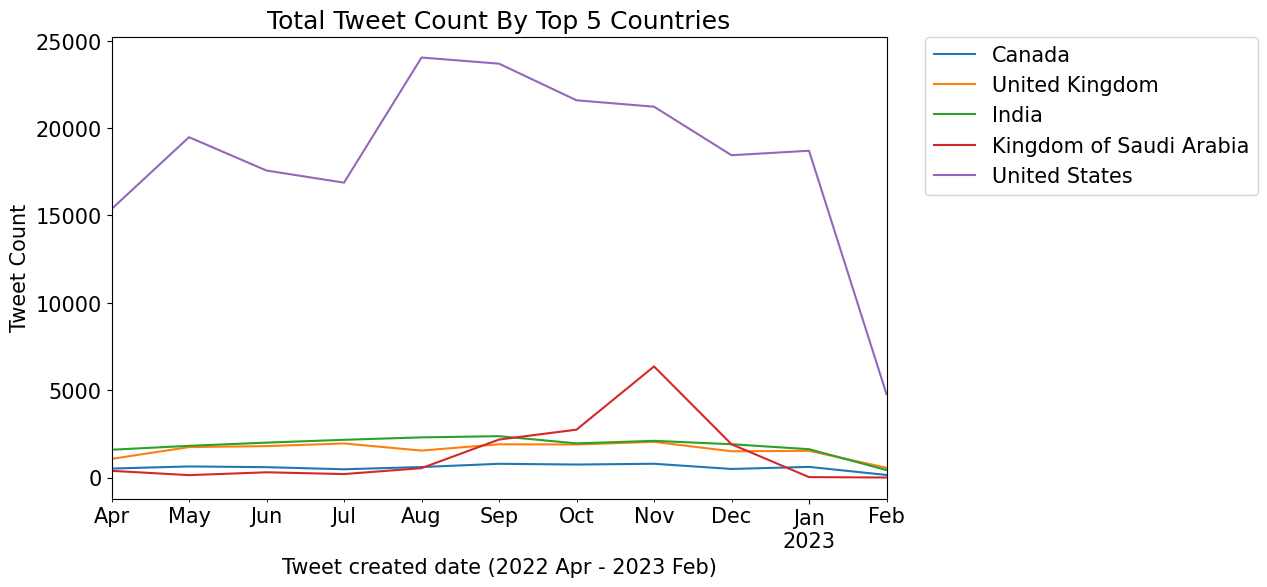

In [227]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 15})

# my_list = ['apple', 'banana', 'orange', 'banana', 'pear']
# my_list = [s.replace('banana', 'kiwi') for s in my_list]

# Extract the country code from the original labels
labels = [label[-1] for label in country_by_date_top5.columns]
labels = [s.replace('US', 'United States') for s in labels]
labels = [s.replace('IN', 'India') for s in labels]
labels = [s.replace('GB', 'United Kingdom') for s in labels]
labels = [s.replace('SA', 'Kingdom of Saudi Arabia') for s in labels]
labels = [s.replace('CA', 'Canada') for s in labels]


country_by_date_top5.plot(title='Total Tweet Count By Top 5 Countries', ylabel='Tweet Count', xlabel = 'Tweet created date (2022 Apr - 2023 Feb)')

plt.legend(labels,loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()

**Analyze user_account created_date trend by country**

In [212]:
account_created_by_country = country.groupBy(['country_code', 'account_created_date']).count().orderBy('count', ascending=False)

In [213]:
account_created_by_country = account_created_by_country.toPandas()

In [214]:
account_created_by_country.sort_values(by='account_created_date', ascending=False)

,country_code,account_created_date,count
31299,IN,2023-02-07,1
30131,CN,2023-02-07,1
14772,US,2023-02-07,2
20137,IN,2023-02-06,1
23230,KE,2023-02-06,1
...,...,...,...
34092,GB,2006-07-18,1
23091,US,2006-07-17,1
26663,PH,2006-07-16,1
30796,US,2006-07-05,1


In [215]:
top10 = account_created_by_country[account_created_by_country['country_code'].str.contains('US') |\
                                  account_created_by_country['country_code'].str.contains('IN') |\
                                  account_created_by_country['country_code'].str.contains('GB') |\
                                  account_created_by_country['country_code'].str.contains('SA') |\
                                  account_created_by_country['country_code'].str.contains('CA') |\
                                  account_created_by_country['country_code'].str.contains('NG') |\
                                  account_created_by_country['country_code'].str.contains('AU') |\
                                  account_created_by_country['country_code'].str.contains('IE') |\
                                  account_created_by_country['country_code'].str.contains('PH') |\
                                  account_created_by_country['country_code'].str.contains('PK') ]

In [216]:
top10['account_created_date'] = pd.to_datetime(top10['account_created_date'], format='%Y-%m-%d')

In [217]:
top10 = top10.groupby([pd.Grouper(key='account_created_date', axis=0, freq='M'), 'country_code']).sum('count').unstack()

In [218]:
top10

count                                                    \
country_code            AU    CA    GB   IE     IN    NG    PH    PK      SA   
account_created_date                                                           
2006-07-31             NaN   NaN   1.0  NaN    NaN   NaN   1.0   NaN     NaN   
2006-08-31             NaN   NaN   NaN  NaN    NaN   NaN   NaN   NaN     NaN   
2006-09-30             NaN   NaN   NaN  NaN    1.0   NaN   NaN   NaN     NaN   
2006-10-31             NaN   NaN   NaN  NaN    2.0   NaN   NaN   NaN     NaN   
2006-11-30             NaN   1.0   4.0  NaN    4.0   NaN   2.0   NaN     NaN   
...                    ...   ...   ...  ...    ...   ...   ...   ...     ...   
2022-10-31             6.0  10.0  30.0  3.0  223.0  44.0  10.0  13.0  4601.0   
2022-11-30             3.0  14.0  18.0  2.0  169.0  20.0   5.0  16.0  1389.0   
2022-12-31             3.0   2.0  12.0  NaN  133.0  12.0   2.0  16.0     1.0   
2023-01-31             NaN   7.0  14.0  NaN   57.0   7.0   NaN  14.0     NaN   
2023-02-28             NaN   1.0   NaN  NaN    4.0   1.0   NaN   1.0     NaN   

                             
country_code             US  
account_created_date         
2006-07-31              4.0  
2006-08-31              2.0  
2006-09-30              5.0  
2006-10-31             15.0  
2006-11-30             19.0  
...                     ...  
2022-10-31            494.0  
2022-11-30            482.0  
2022-12-31            267.0  
2023-01-31            102.0  
2023-02-28             17.0  

[200 rows x 10 columns]

In [219]:
top10.fillna(0, inplace=True)

In [220]:
top10

count                                                    \
country_code            AU    CA    GB   IE     IN    NG    PH    PK      SA   
account_created_date                                                           
2006-07-31             0.0   0.0   1.0  0.0    0.0   0.0   1.0   0.0     0.0   
2006-08-31             0.0   0.0   0.0  0.0    0.0   0.0   0.0   0.0     0.0   
2006-09-30             0.0   0.0   0.0  0.0    1.0   0.0   0.0   0.0     0.0   
2006-10-31             0.0   0.0   0.0  0.0    2.0   0.0   0.0   0.0     0.0   
2006-11-30             0.0   1.0   4.0  0.0    4.0   0.0   2.0   0.0     0.0   
...                    ...   ...   ...  ...    ...   ...   ...   ...     ...   
2022-10-31             6.0  10.0  30.0  3.0  223.0  44.0  10.0  13.0  4601.0   
2022-11-30             3.0  14.0  18.0  2.0  169.0  20.0   5.0  16.0  1389.0   
2022-12-31             3.0   2.0  12.0  0.0  133.0  12.0   2.0  16.0     1.0   
2023-01-31             0.0   7.0  14.0  0.0   57.0   7.0   0.0  14.0     0.0   
2023-02-28             0.0   1.0   0.0  0.0    4.0   1.0   0.0   1.0     0.0   

                             
country_code             US  
account_created_date         
2006-07-31              4.0  
2006-08-31              2.0  
2006-09-30              5.0  
2006-10-31             15.0  
2006-11-30             19.0  
...                     ...  
2022-10-31            494.0  
2022-11-30            482.0  
2022-12-31            267.0  
2023-01-31            102.0  
2023-02-28             17.0  

[200 rows x 10 columns]

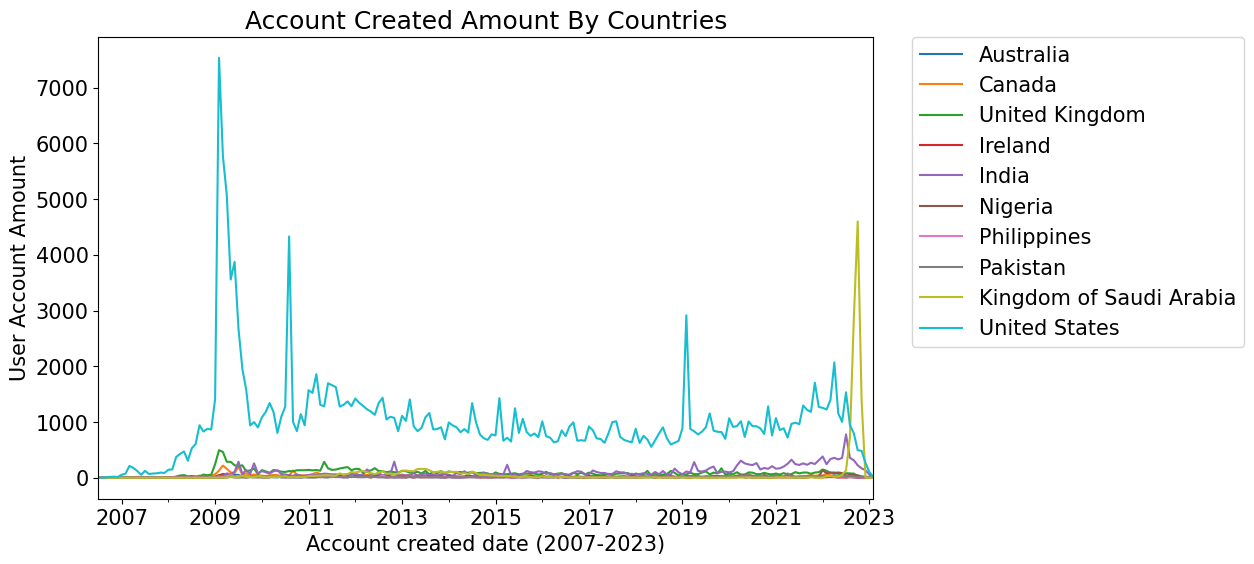

In [226]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 15})


# Extract the country code from the original labels
labels = [label[-1] for label in country_by_date.columns]
labels = [s.replace('US', 'United States') for s in labels]
labels = [s.replace('IN', 'India') for s in labels]
labels = [s.replace('GB', 'United Kingdom') for s in labels]
labels = [s.replace('SA', 'Kingdom of Saudi Arabia') for s in labels]
labels = [s.replace('CA', 'Canada') for s in labels]
labels = [s.replace('NG', 'Nigeria') for s in labels]
labels = [s.replace('AU', 'Australia') for s in labels]
labels = [s.replace('IE', 'Ireland') for s in labels]
labels = [s.replace('PH', 'Philippines') for s in labels]
labels = [s.replace('PK', 'Pakistan') for s in labels]


top10.plot(title='Account Created Amount By Countries', ylabel='User Account Amount', xlabel = 'Account created date (2007-2023)')

plt.legend(labels,loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.show()

##### **Visualize the geographical distribution**

In [41]:
country_dff = edu_df.filter(col('country_name').isNotNull())\
         .groupBy('country_code').count().orderBy(col('count').desc()).limit(20)

In [42]:
country_dff

country_code,count
US,201751
IN,20281
GB,17569
SA,14803
CA,6427
NG,3774
AU,2795
IE,2311
PH,2271
PK,2014


In [43]:
country_dff_pd = country_dff.toPandas()
country_dff_pd

,country_code,count
0,US,201751
1,IN,20281
2,GB,17569
3,SA,14803
4,CA,6427
5,NG,3774
6,AU,2795
7,IE,2311
8,PH,2271
9,PK,2014


In [44]:
country_top_10_ = country_dff_pd[0:10]
country_top_10_

,country_code,count
0,US,201751
1,IN,20281
2,GB,17569
3,SA,14803
4,CA,6427
5,NG,3774
6,AU,2795
7,IE,2311
8,PH,2271
9,PK,2014


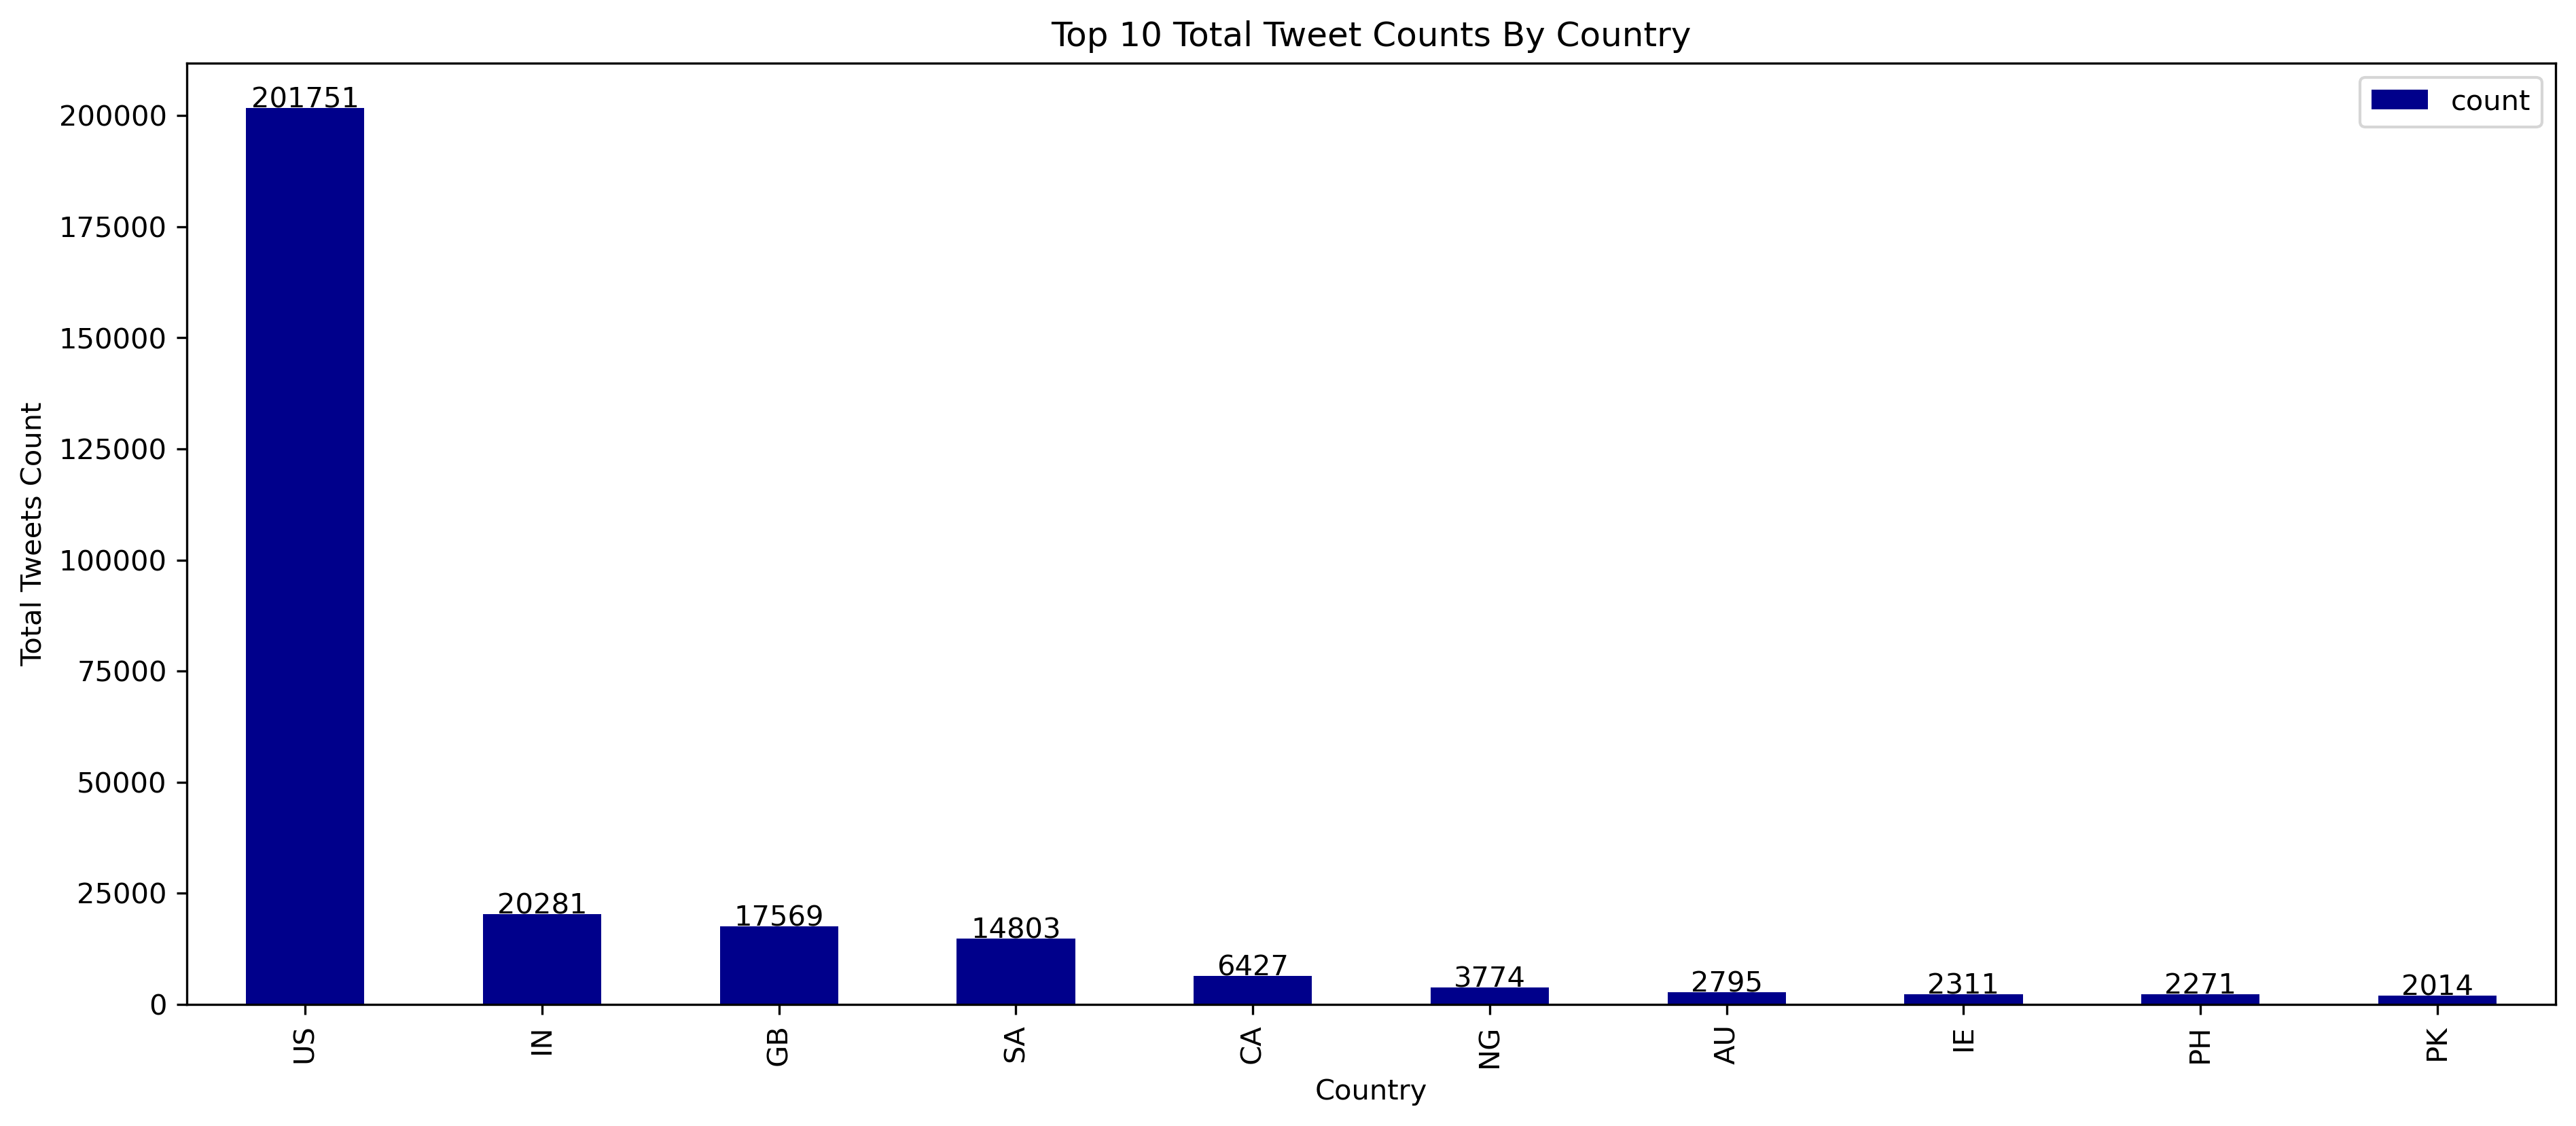

In [113]:
fig, ax = plt.subplots(figsize=(15, 6))
country_top_10_.plot(kind='bar', x='country_code', y='count', color='darkblue', ax=ax)

# add values on top of bars
for i, count in enumerate(country_top_10_['count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=10)

ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 10 Total Tweet Counts By Country')
plt.show()

In [46]:
country_top_10_no_US_ = country_dff_pd[1:10]
country_top_10_no_US_

,country_code,count
1,IN,20281
2,GB,17569
3,SA,14803
4,CA,6427
5,NG,3774
6,AU,2795
7,IE,2311
8,PH,2271
9,PK,2014


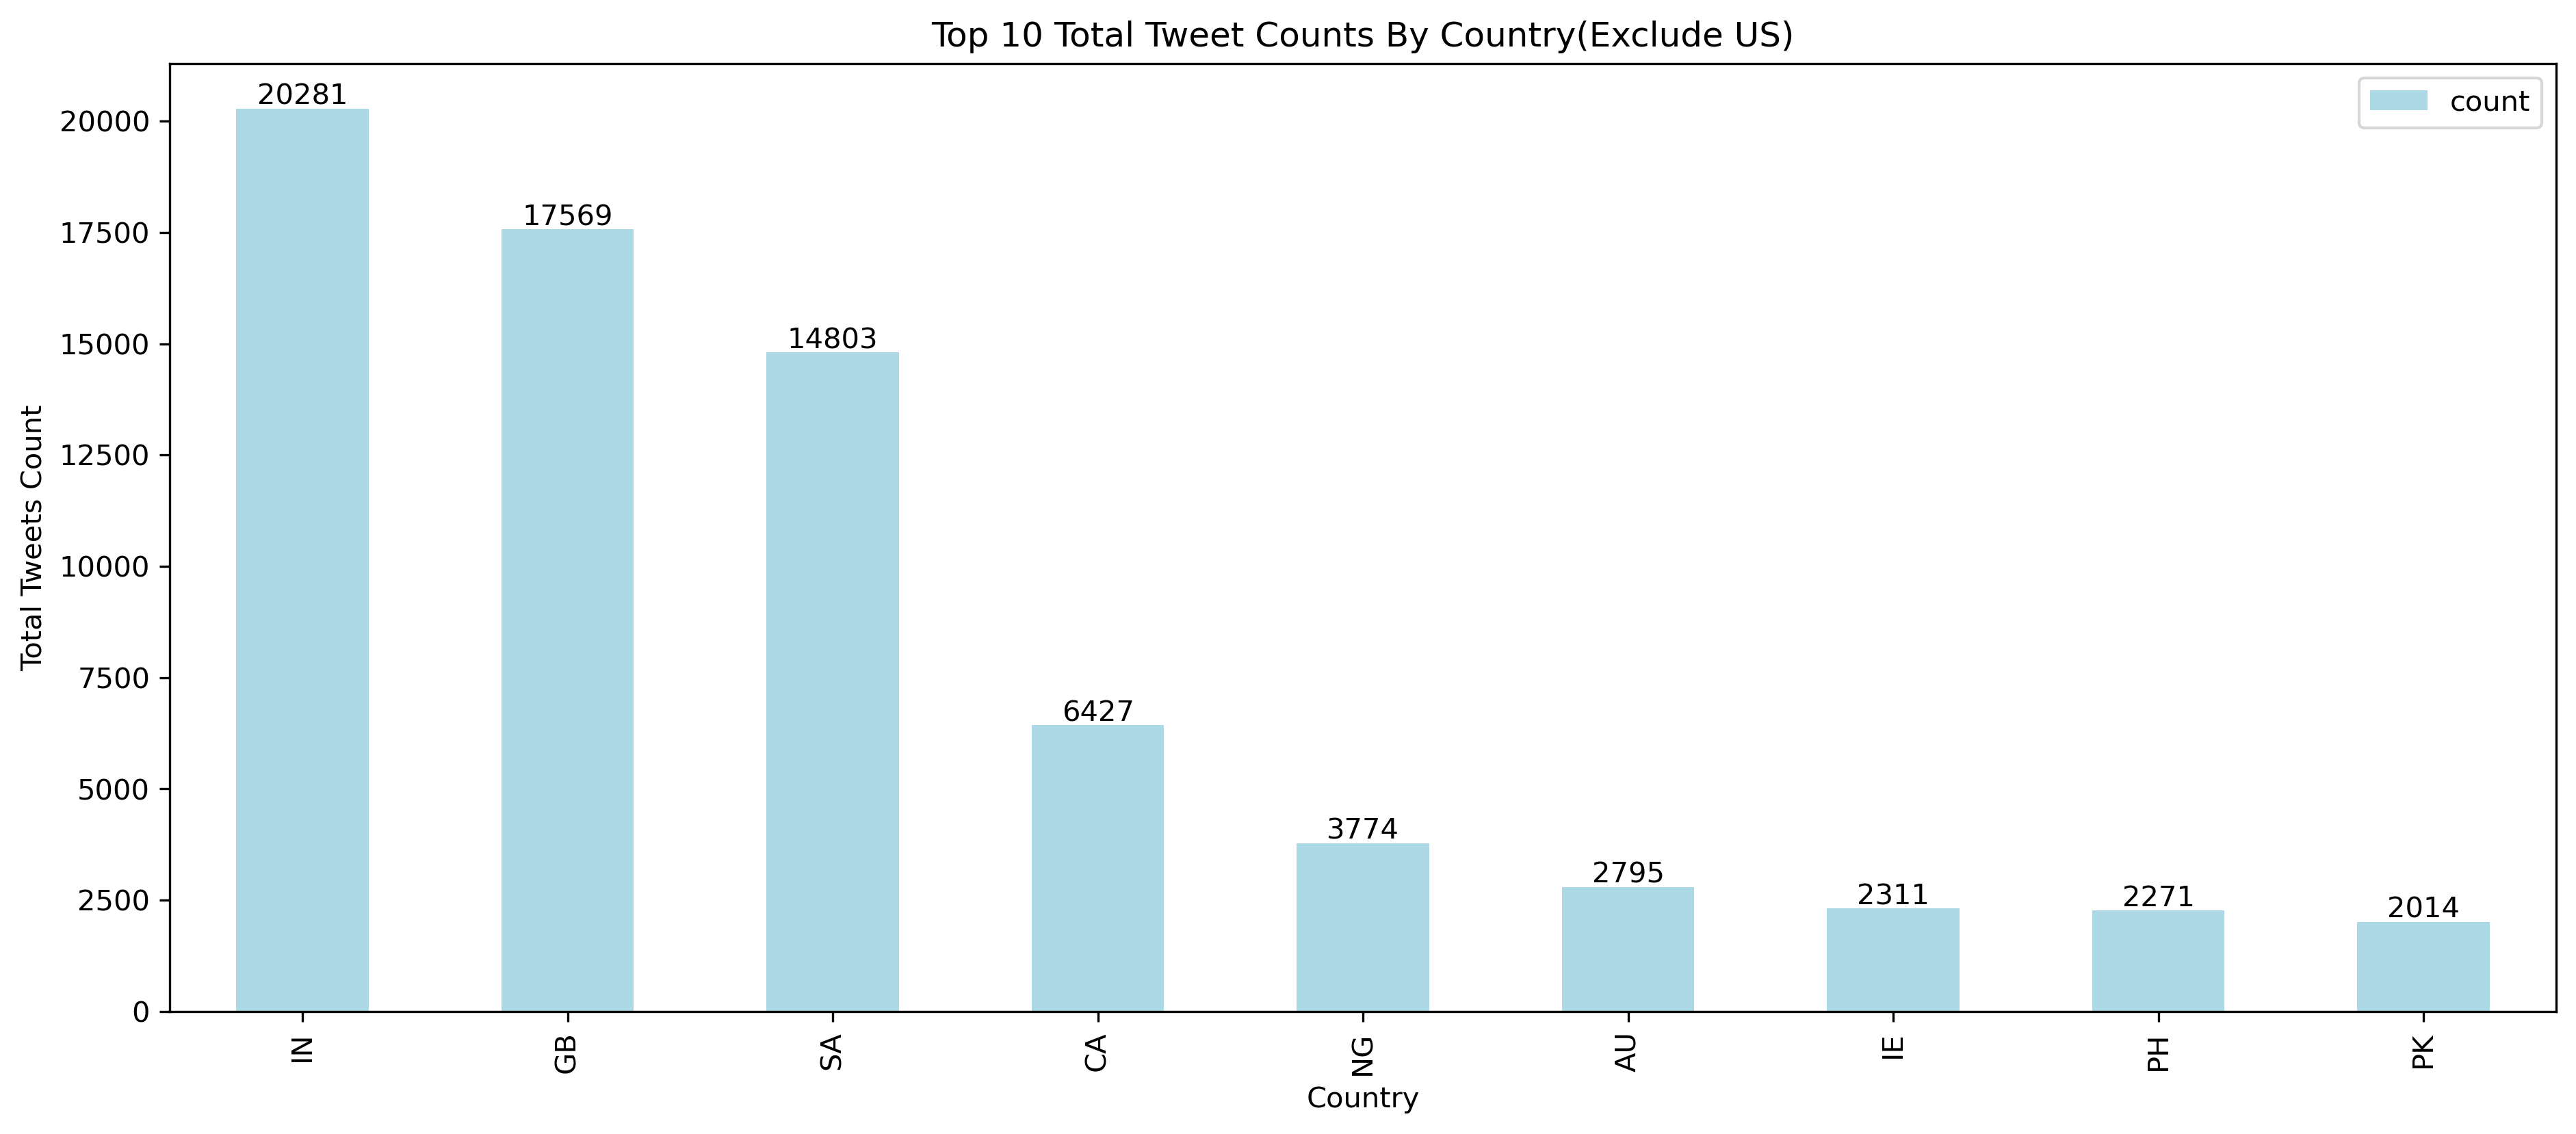

In [99]:
fig, ax = plt.subplots(figsize=(15, 6))

# create bar chart
country_top_10_no_US_.plot(kind='bar', x='country_code', y='count', color='lightblue', ax=ax)


# add values on top of bars
for i, count in enumerate(country_top_10_no_US_['count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=10)

# set axis labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 10 Total Tweet Counts By Country(Exclude US)')
plt.show()

In [114]:
country_top_5_ = country_dff_pd[0:6]
country_top_5_

,country_code,count,iso_a3
0,US,201751,USA
1,IN,20281,IND
2,GB,17569,GBR
3,SA,14803,SAU
4,CA,6427,CAN
5,NG,3774,NGA


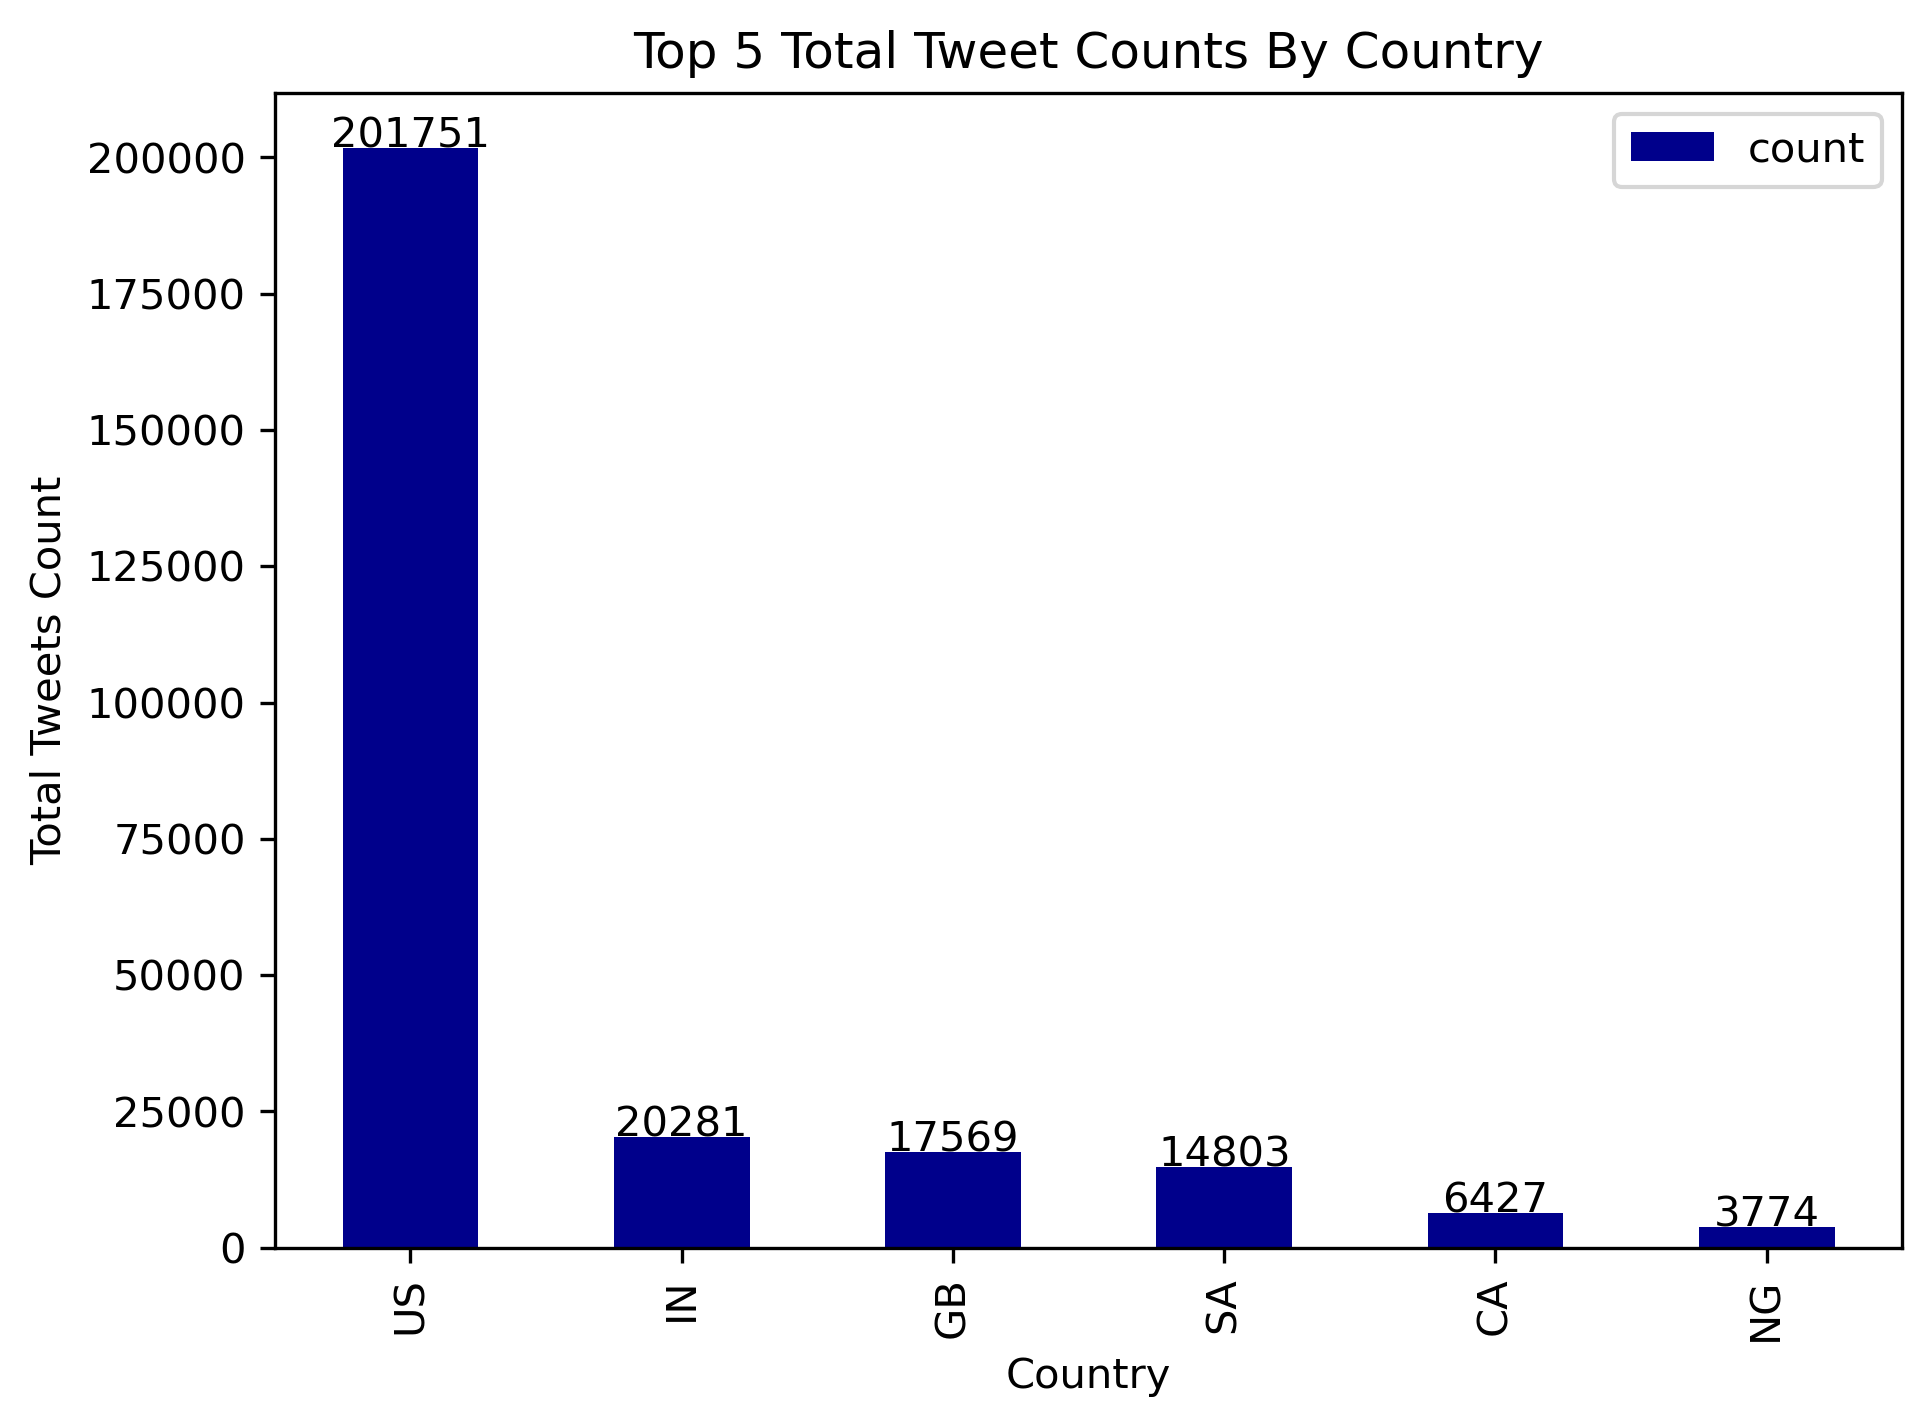

In [125]:
fig, ax = plt.subplots(figsize=(7, 5))
country_top_5_.plot(kind='bar', x='country_code', y='count', color='darkblue', ax=ax)

# add values on top of bars
for i, count in enumerate(country_top_5_['count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=10)

ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 5 Total Tweet Counts By Country')
plt.show()

In [121]:
country_top_5_no_US_ = country_dff_pd[1:6]
country_top_5_no_US_

,country_code,count,iso_a3
1,IN,20281,IND
2,GB,17569,GBR
3,SA,14803,SAU
4,CA,6427,CAN
5,NG,3774,NGA


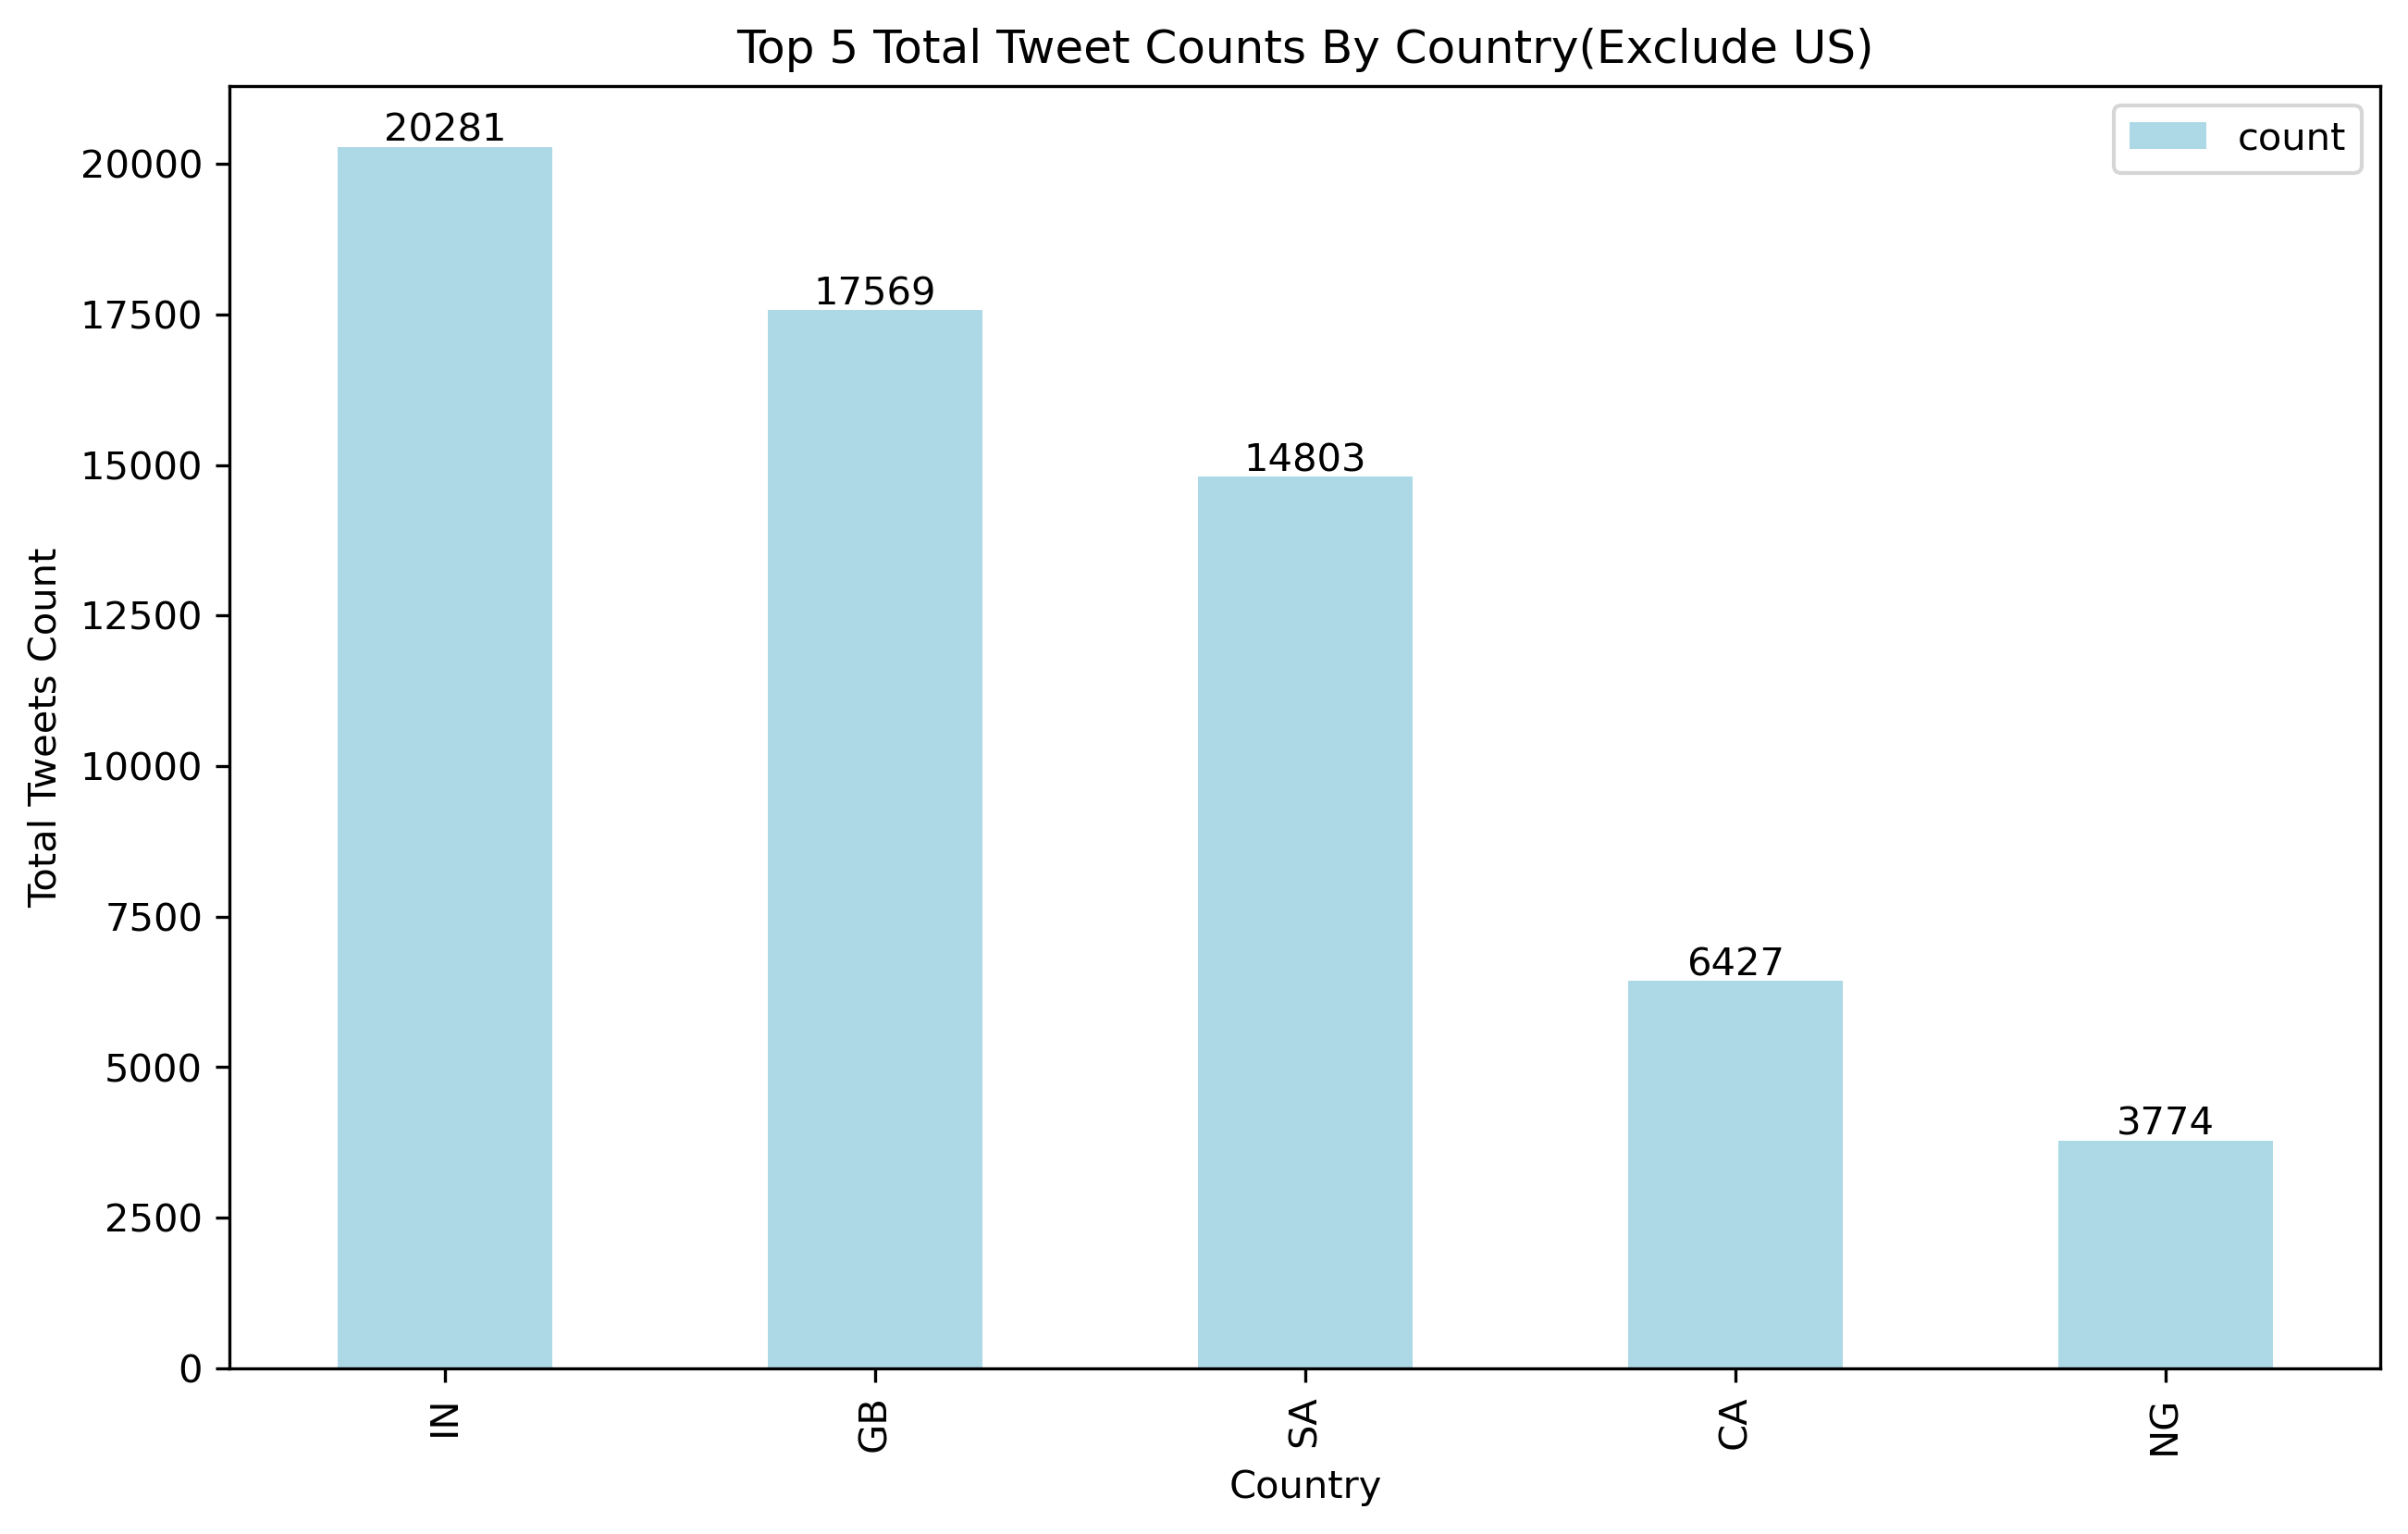

In [123]:
fig, ax = plt.subplots(figsize=(10, 6))

# create bar chart
country_top_5_no_US_.plot(kind='bar', x='country_code', y='count', color='lightblue', ax=ax)


# add values on top of bars
for i, count in enumerate(country_top_5_no_US_['count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=10)

# set axis labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 5 Total Tweet Counts By Country(Exclude US)')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
country_top_10_.plot(kind='bar', x='country_code', y='count', color='darkblue', ax=ax)

# add values on top of bars
for i, count in enumerate(country_top_10_['count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=10)

ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 10 Total Tweet Counts By Country')
plt.show()

In [48]:
# Define a function to get the ISO code for a given country code in order to merge world df & country df on iso_a3
def get_iso_code(country_code):
    """
    Takes a 2-letter country code and returns the corresponding ISO code (3-letter) using pycountry.
    """
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.alpha_3
    except KeyError:
        return None

# Apply the function to a pandas DataFrame column containing country names
country_dff_pd['iso_a3'] = country_dff_pd['country_code'].apply(get_iso_code)
country_dff_pd

,country_code,count,iso_a3
0,US,201751,USA
1,IN,20281,IND
2,GB,17569,GBR
3,SA,14803,SAU
4,CA,6427,CAN
5,NG,3774,NGA
6,AU,2795,AUS
7,IE,2311,IRL
8,PH,2271,PHL
9,PK,2014,PAK


In [50]:
# import world from geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.drop(columns=['pop_est', 'gdp_md_est'])
world.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


continent                      name iso_a3  \
0        Oceania                      Fiji    FJI   
1         Africa                  Tanzania    TZA   
2         Africa                 W. Sahara    ESH   
3  North America                    Canada    CAN   
4  North America  United States of America    USA   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [51]:
merged_dff = world.merge(country_dff_pd, on='iso_a3', how='left')

In [52]:
merged_dff['tweet_count'] = merged_dff['count'].fillna(0).astype(int)

Text(35.703004046157545, 0.5, 'Longitude')

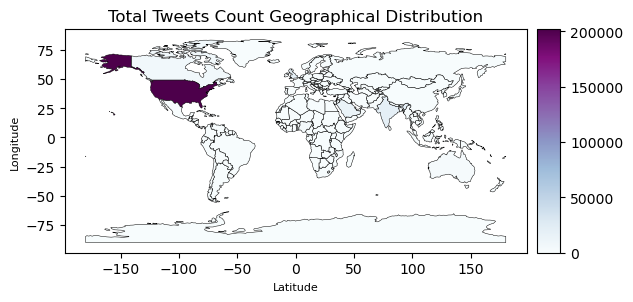

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world_tweet_tomap_ = merged_dff[(merged_dff['tweet_count'] >= 0)]

world_tweet_tomap_.plot(column='tweet_count', ax=ax, 
                       legend=True, cmap='BuPu', cax=cax, edgecolor='black', linewidth=0.35)

ax.set_title('Total Tweets Count Geographical Distribution', fontsize=12)
ax.set_xlabel('Latitude', fontsize=8)
ax.set_ylabel('Longitude', fontsize=8)

In [54]:
country_df = edu_df.filter(col('country_name').isNotNull())\
         .groupBy('country_name').count().orderBy(col('count').desc()).limit(20)

In [55]:
country_df

country_name,count
United States,201415
India,20112
United Kingdom,17500
Kingdom of Saudi ...,12046
Canada,6405
Nigeria,3774
Australia,2795
المملكة العربية ا...,2728
Ireland,2278
Republic of the P...,2260


In [56]:
country_df_pd = country_df.toPandas()

In [57]:
country_df_pd

,country_name,count
0,United States,201415
1,India,20112
2,United Kingdom,17500
3,Kingdom of Saudi Arabia,12046
4,Canada,6405
5,Nigeria,3774
6,Australia,2795
7,المملكة العربية السعودية,2728
8,Ireland,2278
9,Republic of the Philippines,2260


In [58]:
country_df_pd = country_df_pd.replace("المملكة العربية السعودية", "Saudi Arabia")
country_df_pd

,country_name,count
0,United States,201415
1,India,20112
2,United Kingdom,17500
3,Kingdom of Saudi Arabia,12046
4,Canada,6405
5,Nigeria,3774
6,Australia,2795
7,Saudi Arabia,2728
8,Ireland,2278
9,Republic of the Philippines,2260


In [59]:
country_top_10 = country_df_pd[0:10]
country_top_10

,country_name,count
0,United States,201415
1,India,20112
2,United Kingdom,17500
3,Kingdom of Saudi Arabia,12046
4,Canada,6405
5,Nigeria,3774
6,Australia,2795
7,Saudi Arabia,2728
8,Ireland,2278
9,Republic of the Philippines,2260


In [60]:
# ax = country_top_10.plot(kind = 'bar', x = 'country_name', y = 'count', color='lightblue')
# ax.set_xlabel('Country')
# ax.set_ylabel('Total Tweets Count')
# ax.set_title('Top 10 Total Tweet Counts By Country')

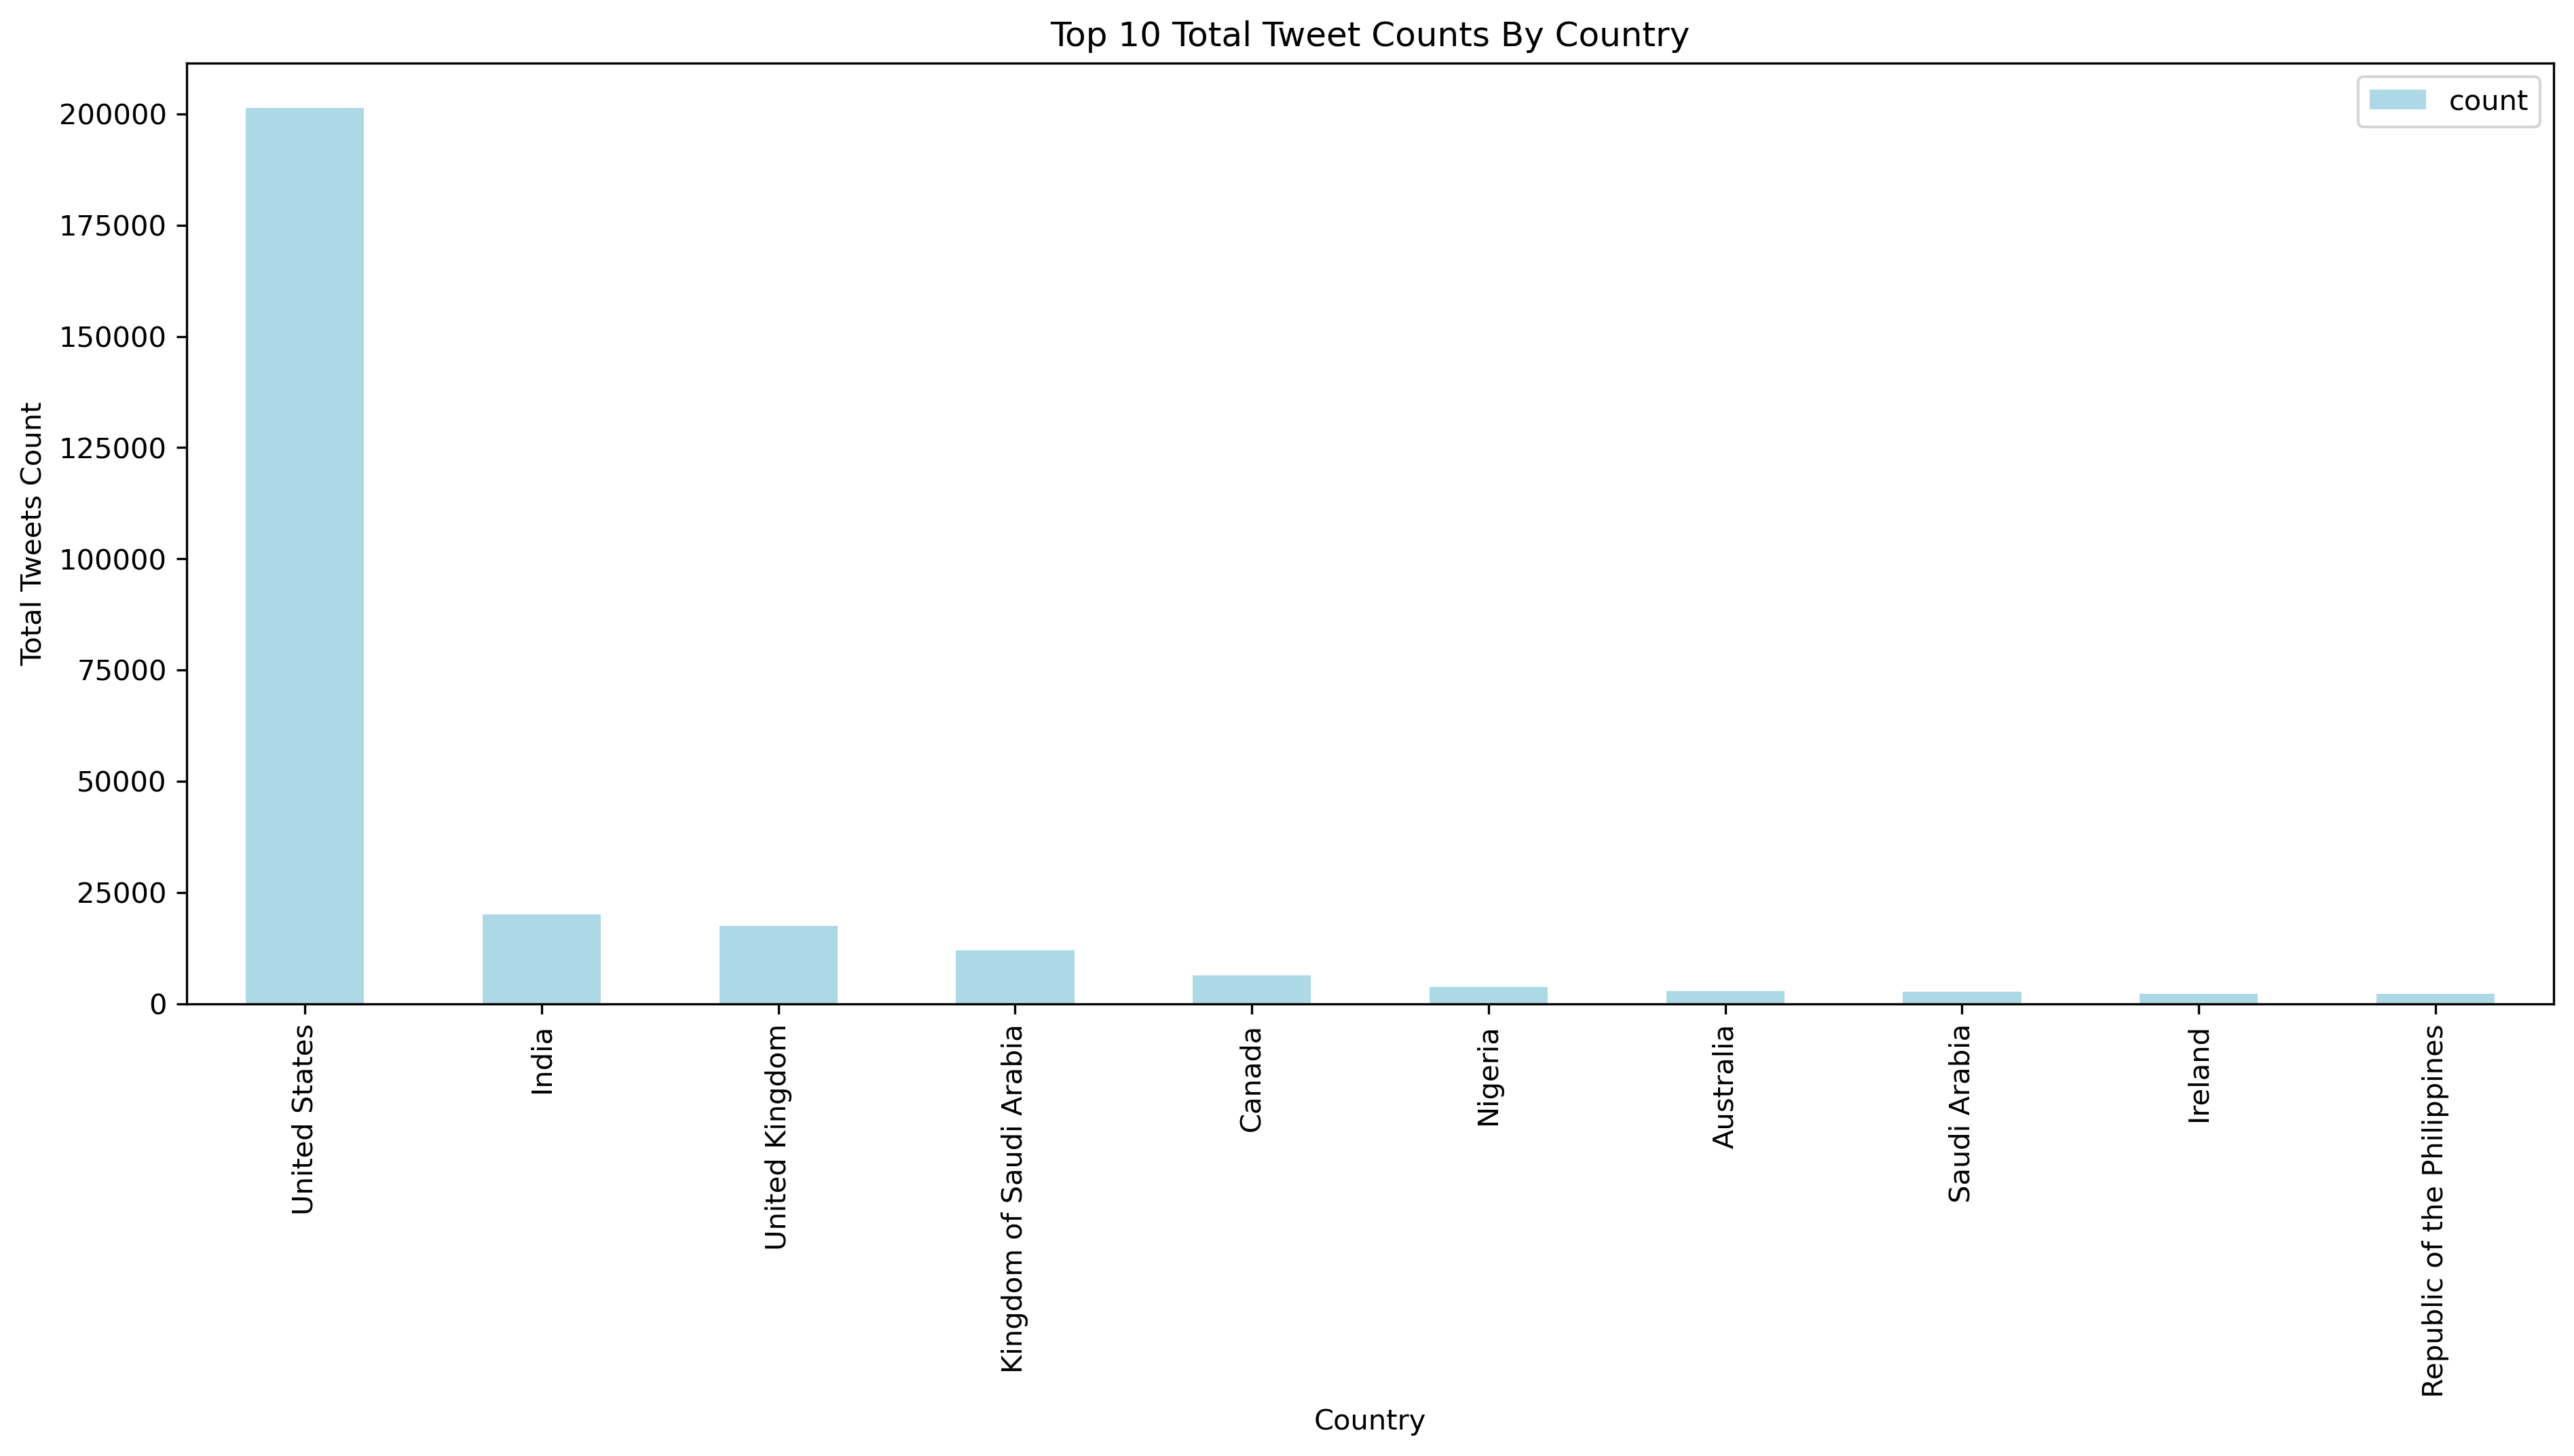

In [61]:
fig, ax = plt.subplots(figsize=(15, 6))
country_top_10.plot(kind='bar', x='country_name', y='count', color='lightblue', ax=ax)
ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 10 Total Tweet Counts By Country')
plt.show()

In [62]:
country_top_10_no_US = country_df_pd[1:10]
country_top_10_no_US

,country_name,count
1,India,20112
2,United Kingdom,17500
3,Kingdom of Saudi Arabia,12046
4,Canada,6405
5,Nigeria,3774
6,Australia,2795
7,Saudi Arabia,2728
8,Ireland,2278
9,Republic of the Philippines,2260


In [67]:
# Define a function to get the ISO code for a given country name in order to merge world df & country df on iso_a3
def get_iso_code(country_name):
    try:
        return pycountry.countries.get(name=country_name).alpha_3
    except:
        return None

In [68]:
country_top_10_no_US['iso_a3'] = country_top_10_no_US['country_name'].apply(get_iso_code)

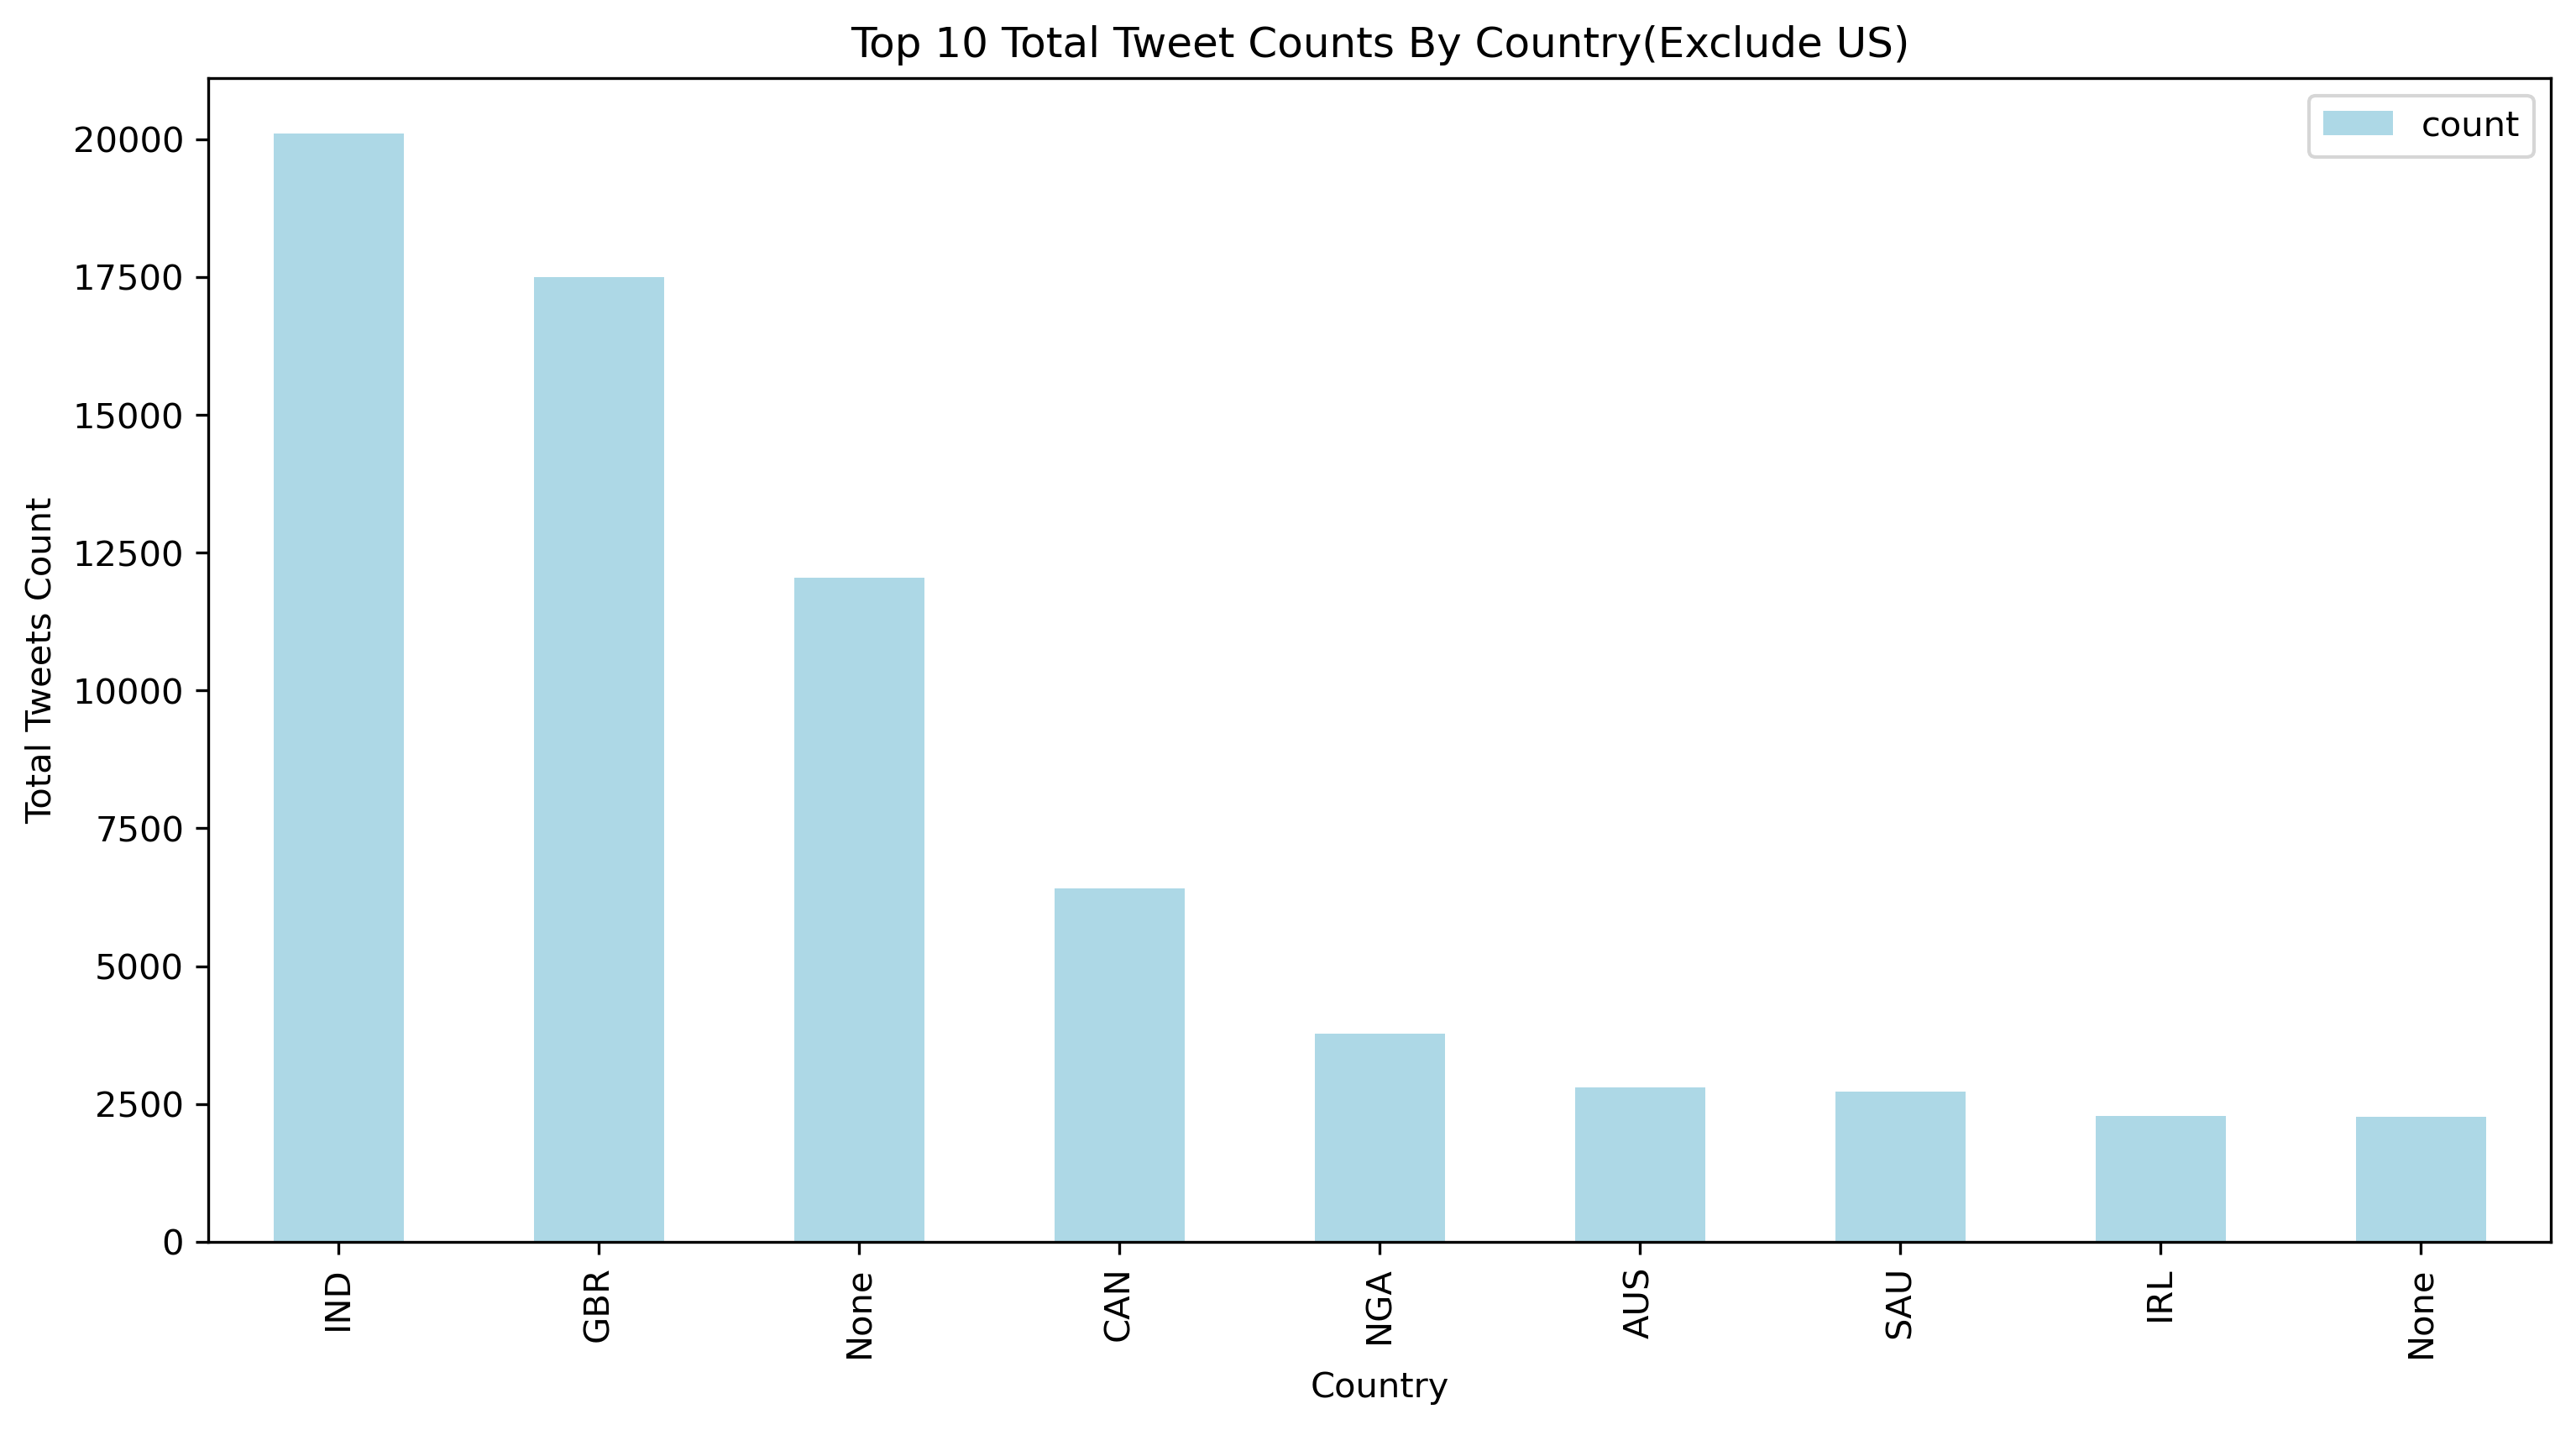

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))
country_top_10_no_US.plot(kind='bar', x='iso_a3', y='count', color='lightblue', ax=ax)
ax.set_xlabel('Country')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Top 10 Total Tweet Counts By Country(Exclude US)')
plt.show()

In [ ]:
# Create a choropleth map using Plotly
fig = px.choropleth(country_df_pd, locations='country_name', locationmode='country names', color='count',
                    title='Geographical Distribution of Total Tweet Counts', hover_name='country_name',
                    projection='natural earth')
fig.show()

In [ ]:
# import pandas as pd
# import plotly.express as px

# # Create a sample DataFrame
# data = {'Country': ['USA', 'Canada', 'Mexico', 'Brazil', 'Argentina'],
#         'Value': [10, 5, 15, 20, 8]}
# df = pd.DataFrame(data)

# # Create a choropleth map using Plotly
# fig = px.choropleth(df, locations='Country', locationmode='country names', color='Value',
#                     title='Geographical Distribution', hover_name='Country',
#                     projection='natural earth')
# fig.show()


In [ ]:
# # set a variable that will call whatever column we want to visualise on the map
# variable = 'count'
# # set the range for the choropleth
# vmin, vmax = 120, 220
# # create figure and axes for Matplotlib
# fig, ax = plt.subplots(1, figsize=(10, 6))

# # create map
# country_df_pd.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)


In [ ]:
world['name'].unique()

In [71]:
country_name_list = list(world['name'].unique())

In [72]:
country_df_pd_list = list(country_df_pd['country_name'])

In [73]:
country_df_pd_list

['United States',
 'India',
 'United Kingdom',
 'Kingdom of Saudi Arabia',
 'Canada',
 'Nigeria',
 'Australia',
 'Saudi Arabia',
 'Ireland',
 'Republic of the Philippines',
 'Pakistan',
 'South Africa',
 'Kenya',
 'Ghana',
 'Uganda',
 'Malaysia',
 'United Arab Emirates',
 'New Zealand',
 'Germany',
 'Indonesia']

In [74]:
for country in country_df_pd_list:
    if country in country_name_list:
        print(country)     

India
United Kingdom
Canada
Nigeria
Australia
Saudi Arabia
Ireland
Pakistan
South Africa
Kenya
Ghana
Uganda
Malaysia
United Arab Emirates
New Zealand
Germany
Indonesia


In [75]:
# # Define a function to get the ISO code for a given country name in order to merge world df & country df on iso_a3
# def get_iso_code(country_name):
#     try:
#         return pycountry.countries.get(name=country_name).alpha_3
#     except:
#         return None

# Apply the function to a pandas DataFrame column containing country names
country_df_pd['iso_a3'] = country_df_pd['country_name'].apply(get_iso_code)
country_df_pd

,country_name,count,iso_a3
0,United States,201415,USA
1,India,20112,IND
2,United Kingdom,17500,GBR
3,Kingdom of Saudi Arabia,12046,None
4,Canada,6405,CAN
5,Nigeria,3774,NGA
6,Australia,2795,AUS
7,Saudi Arabia,2728,SAU
8,Ireland,2278,IRL
9,Republic of the Philippines,2260,None


In [76]:
# merge dataframe
merge_df = world.merge(country_df_pd, on='iso_a3', how='left')
merge_df.head()

continent                      name iso_a3  \
0        Oceania                      Fiji    FJI   
1         Africa                  Tanzania    TZA   
2         Africa                 W. Sahara    ESH   
3  North America                    Canada    CAN   
4  North America  United States of America    USA   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [77]:
merge_df.isna().sum()

continent         0
name              0
iso_a3            0
geometry          0
country_name    159
count           159
dtype: int64

In [78]:
merge_df.shape

(177, 6)

In [79]:
# fill na values
merge_df['tweet_count'] = merge_df['count'].fillna(0).astype(int)

Text(167.63133896667003, 0.5, 'Longitude')

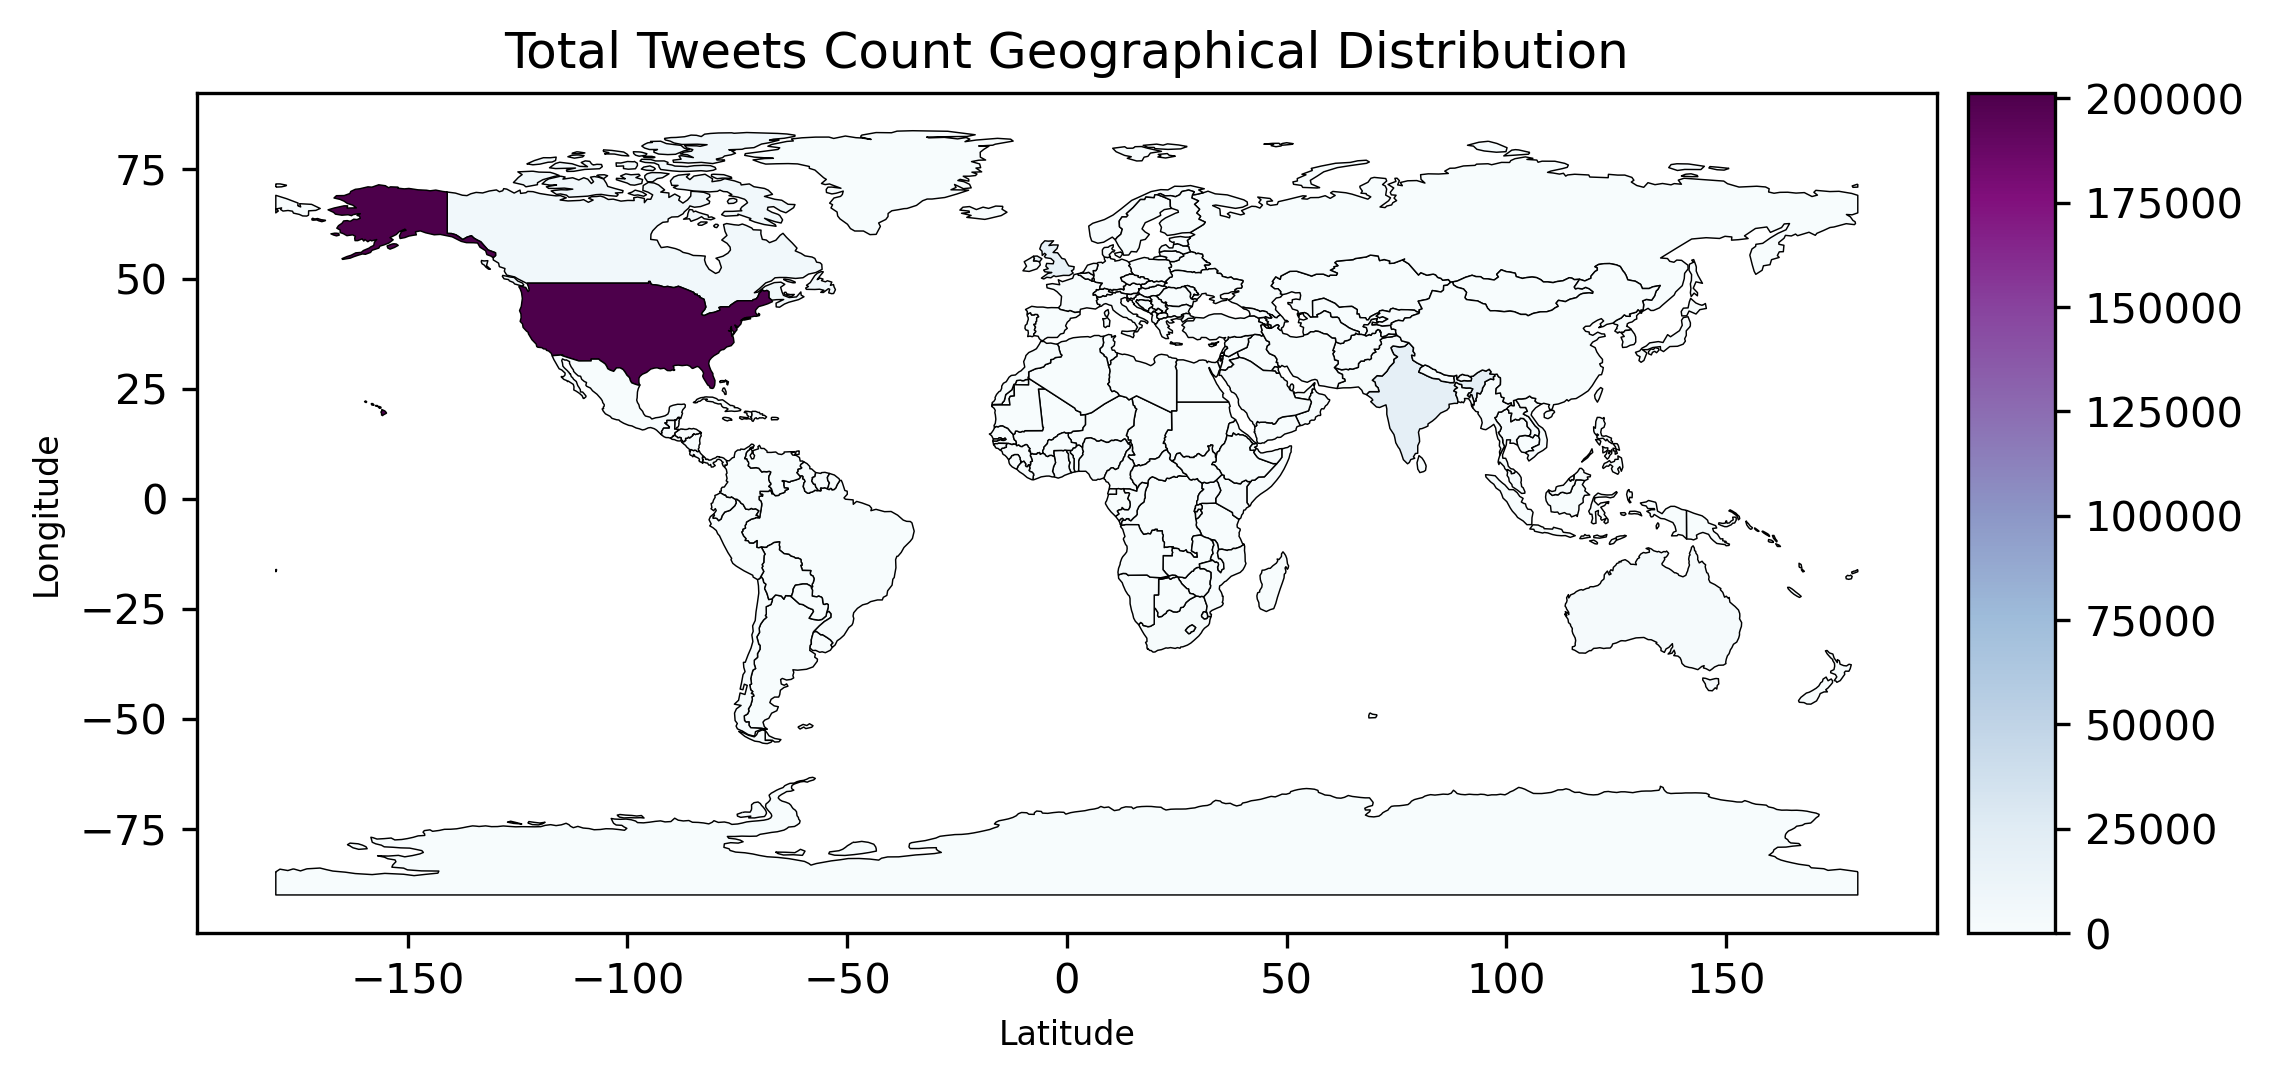

In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world_tweet_tomap = merge_df[(merge_df['tweet_count'] >= 0)]

world_tweet_tomap.plot(column='tweet_count', ax=ax, 
                       legend=True, cmap='BuPu', cax=cax, edgecolor='black', linewidth=0.35)

ax.set_title('Total Tweets Count Geographical Distribution', fontsize=12)
ax.set_xlabel('Latitude', fontsize=8)
ax.set_ylabel('Longitude', fontsize=8)

In [81]:
# Define a function to get the continent for a given country name
def get_continent(country_name):
    try:
        # Get the ISO code for the given country name
        country_code = pycountry.countries.get(name=country_name).alpha_2
        # Convert the ISO code to a continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Convert the continent code to a continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

# Apply the function to a pandas DataFrame column containing country names
country_df_pd['continent'] = country_df_pd['country_name'].apply(get_continent)
country_df_pd

,country_name,count,iso_a3,continent
0,United States,201415,USA,North America
1,India,20112,IND,Asia
2,United Kingdom,17500,GBR,Europe
3,Kingdom of Saudi Arabia,12046,None,None
4,Canada,6405,CAN,North America
5,Nigeria,3774,NGA,Africa
6,Australia,2795,AUS,Oceania
7,Saudi Arabia,2728,SAU,Asia
8,Ireland,2278,IRL,Europe
9,Republic of the Philippines,2260,None,None


In [82]:
country_df_pd['continent'] = country_df_pd['continent'].fillna('Asia')
country_df_pd

,country_name,count,iso_a3,continent
0,United States,201415,USA,North America
1,India,20112,IND,Asia
2,United Kingdom,17500,GBR,Europe
3,Kingdom of Saudi Arabia,12046,None,Asia
4,Canada,6405,CAN,North America
5,Nigeria,3774,NGA,Africa
6,Australia,2795,AUS,Oceania
7,Saudi Arabia,2728,SAU,Asia
8,Ireland,2278,IRL,Europe
9,Republic of the Philippines,2260,None,Asia


In [83]:
continent_df_count = country_df_pd.groupby(['continent']).count().reset_index()
continent_df_count

,continent,country_name,count,iso_a3
0,Africa,5,5,5
1,Asia,8,8,6
2,Europe,3,3,3
3,North America,2,2,2
4,Oceania,2,2,2


In [84]:
continent_df = country_df_pd.groupby(['continent']).sum().reset_index()
continent_df = continent_df.sort_values(by=['count'], ascending=False)
continent_df

,continent,count
3,North America,207820
1,Asia,40502
2,Europe,20189
0,Africa,8759
4,Oceania,3234


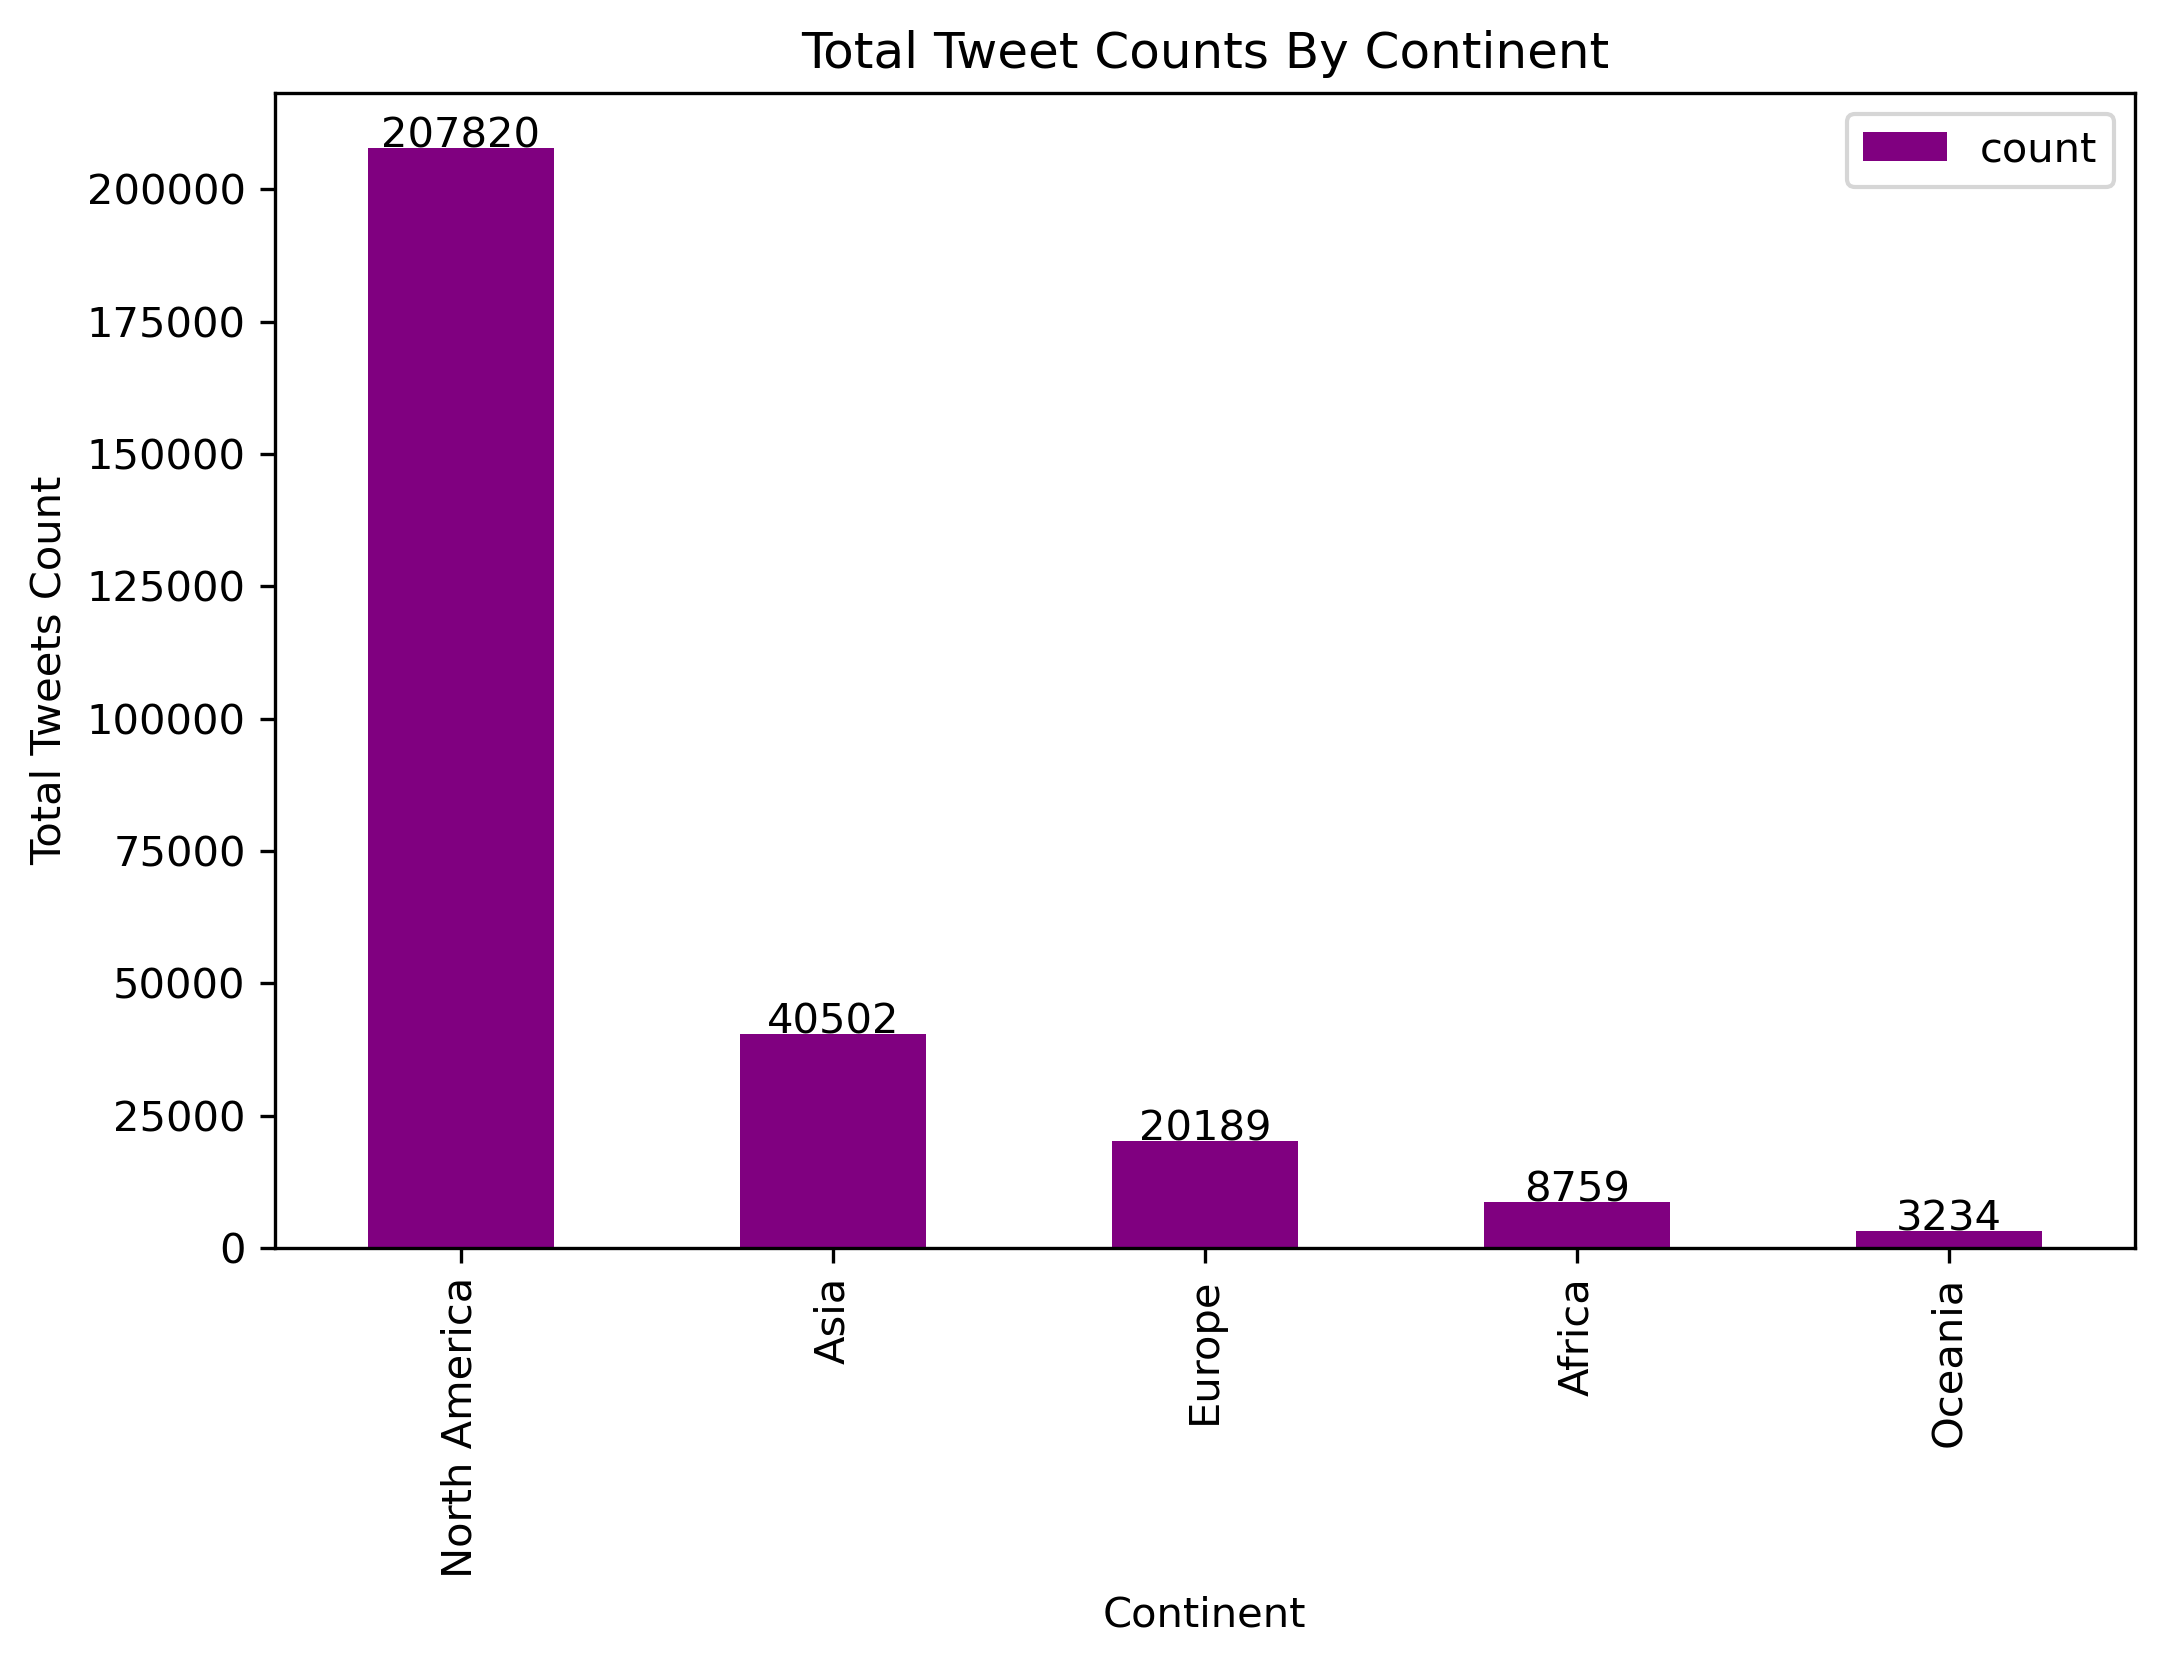

In [112]:
fig, ax = plt.subplots(figsize=(8, 5))
continent_df .plot(kind='bar', x='continent', y='count', color='purple', ax=ax)


# add values on top of bars
for i, count in enumerate(continent_df['count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=10)


ax.set_xlabel('Continent')
ax.set_ylabel('Total Tweets Count')
ax.set_title('Total Tweet Counts By Continent')
plt.show()

In [126]:
world['continent'].unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

In [127]:
merge_df2 = world.merge(continent_df, on='continent', how = 'inner')
merge_df2.head(10)

continent              name iso_a3  \
0   Oceania              Fiji    FJI   
1   Oceania  Papua New Guinea    PNG   
2   Oceania           Vanuatu    VUT   
3   Oceania     New Caledonia    NCL   
4   Oceania       Solomon Is.    SLB   
5   Oceania       New Zealand    NZL   
6   Oceania         Australia    AUS   
7    Africa          Tanzania    TZA   
8    Africa         W. Sahara    ESH   
9    Africa   Dem. Rep. Congo    COD   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [128]:
merge_df2['continent'].unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'Europe'],
      dtype=object)

Text(167.63133896666974, 0.5, 'Longitude')

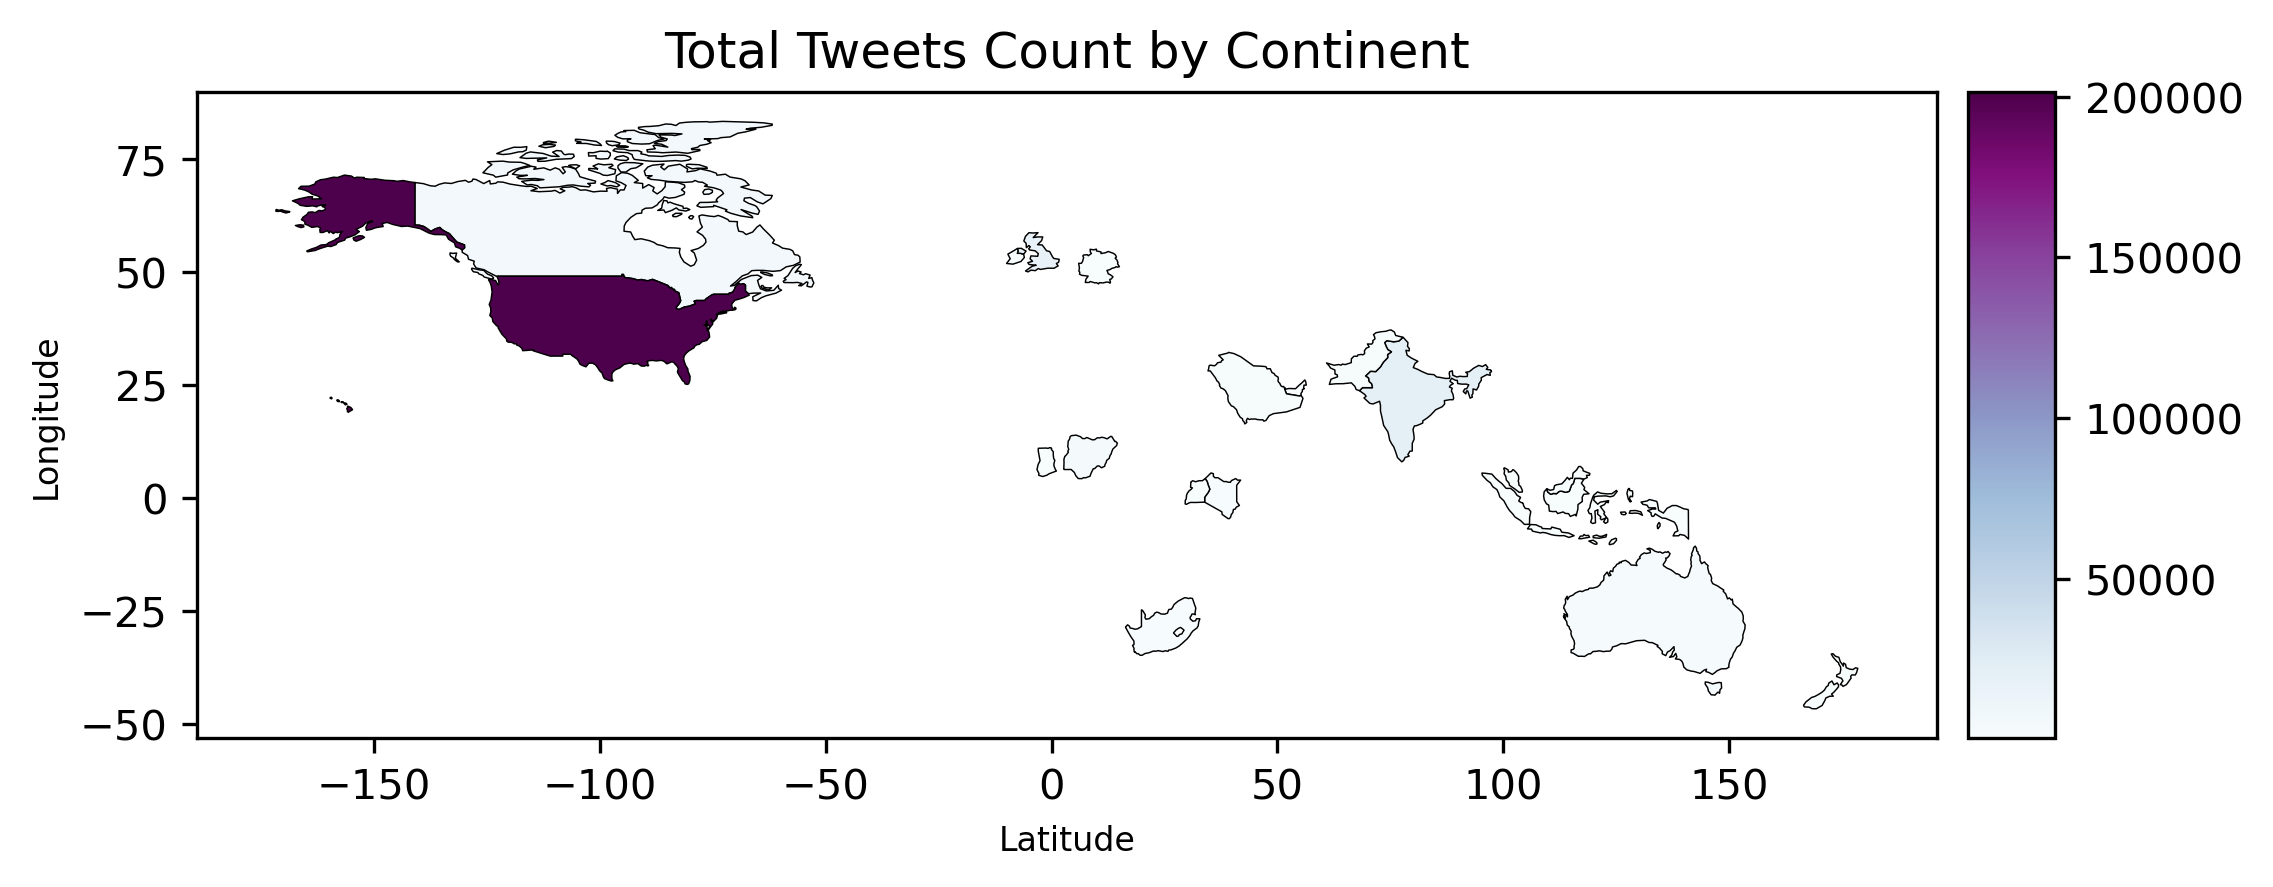

In [87]:
fig, ax = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

#world_tweet_tomap = merge_df[(merge_df['tweet_count'] >= 0)]
# world_tweet_tomap = merge_df[(merge_df['tweet_count'] >= 0)]

# world_tweet_tomap.plot(column='tweet_count', ax=ax, 
#                        legend=True, cmap='BuPu', cax=cax, edgecolor='black', linewidth=0.35)

# ax.set_title('Total Tweets Count Geographical Distribution', fontsize=12)
# ax.set_xlabel('Latitude', fontsize=8)
# ax.set_ylabel('Longitude', fontsize=8)


merge_df.plot(column='count', ax=ax, 
                       legend=True, cmap='BuPu', cax=cax, edgecolor='black', linewidth=0.35)

ax.set_title('Total Tweets Count by Continent', fontsize=12)
ax.set_xlabel('Latitude', fontsize=8)
ax.set_ylabel('Longitude', fontsize=8)

In [88]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Tue, 07 March 2023 10:37:34'